# simple model emulators of each ESM

Can we emulate land carbon sink?

Use a box model framework and fit the parameters to each ESM

fit using ZEC, test using CDR


### Box Model
$NPP = NBP + RH$ 
$flr = 1 - 1\tau_L$ 

$\frac{d M_V}{dt} = NPP - \frac{M_V}{\tau_V}$

$\frac{d M_L}{dt} = \frac{M_V}{\tau_V} - \frac{M_L}{\tau_L} - flr \cdot M_L \cdot Q_{10}^{T/10}$

$\frac{d M_S}{dt} = \cdot \frac{M_L}{\tau_L} - \frac{M_S}{\tau_S} \cdot Q_{10}^{T/10}$


    
##### solve for Q10 from RH 
$RH = flr \cdot M_L \cdot Q_{10}^{T/10} + \frac{M_S}{\tau_S} \cdot Q_{10}^{T/10}$

can be rearranged as follows
$a^x=exp(x \cdot log(a))$

$\frac{RH}{M_L+M_S} = exp[T/10 \cdot log(Q_{10})]$  
$10/T \cdot log(\frac{RH}{flr \cdot M_L+\frac{M_S}{\tau_S}}) = log(Q_{10})$  
$Q_{10} = exp[10/T \cdot log(\frac{RH}{flr \cdot M_L+\frac{M_S}{\tau_S}}) ]$  

##### solve for NPP from NBP and RH

$NPP = NBP+RH$  

#### Input fields
$nbp$
$rh$
$T$

A different assumption would be to start with $C_{atm}$ and use beta to predict gpp  with $(1+\beta \cdot log(\frac{C_{atm}}{C_O}))$ 

#### Unknown constants
$tau_V$  
$tau_L$  
$tau_S$

#### Solve for 
$M_V$  
$M_L$  
$M_S$


In [123]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

from scipy.optimize import minimize


from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


In [124]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [125]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]


latlist=['global','highlat','troplat','midlat']


In [4]:
# choose one model for now
model='CESM2'

In [5]:
# # get grid info

# # initialize a dictionary to hold all of the data
# data_dict={}

# #-- load grid info
# data_dict = load_grid(data_dict,modellist)

# # get area and landfrac from the dictionary where they have been pre-loaded
# ds_area = data_dict[modellist[m] +'_' +'areacella']
# ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']

# if model=='CESM2':
#     area = ds_area['areacella'].squeeze().reindex_like(ds_landfrac, method='nearest',tolerance=0.05)
# else:
#     area = ds_area['areacella'].reindex_like(ds_landfrac, method='nearest',tolerance=0.05)

# # landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)

# if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
#     landfrac=landfrac/100
    
# landarea=area*landfrac

# landaream2=landarea.sum().values

In [6]:
# landaream2

In [7]:
# load timeseries of data
ds_C_global = xr.open_dataset("C_metrics_matrix_S.nc")

In [8]:
ds_C_global


<xarray.Dataset> Size: 3MB
Dimensions:   (time: 350, model: 9, run: 3, var: 9, latrange: 4)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
  * model     (model) <U13 468B 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1.2'
  * run       (run) <U10 120B 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) <U7 252B 'cVeg' 'cSoil' 'cLitter' ... 'tas' 'pr' 'cTot'
  * latrange  (latrange) <U7 112B 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 3MB ...

In [13]:
# assign data from output

l=0 # global

# for m in range(len(modellist)):
#     model=modellist[m]
#     mcolor=modelcolors[m]

    
#     e=0 #flat10
#     timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
#                                    var=varlist[v], latrange=latlist[l])
#     e=1 #zec
#     timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
#                                    var=varlist[v], latrange=latlist[l])
    
#     Ctszec=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) 



#--- GPP
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='gpp', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='gpp', latrange='global')

GPP=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
GPP_tszec= GPP *  speryr #convert from Pg/s to Pg/yr


#--- TAS
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='tas', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='tas', latrange='global')

T=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
T_tszec = T-273.15

#--- RH
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='rh', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='rh', latrange='global')

RH=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
RH_tszec= RH *  speryr #convert from Pg/s to Pg/yr

#--- NBP
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='nbp', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='nbp', latrange='global')

NBP=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
NBP_tszec= NBP *  speryr #convert from Pg/s to Pg/yr


In [114]:
#--- cVeg
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='cVeg', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='cVeg', latrange='global')

cVeg=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
cVeg_tszec= cVeg 

#--- cLitter
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='cLitter', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='cLitter', latrange='global')

cLitter=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
cLitter_tszec= cLitter


#--- cSoil
e=0 #flat10
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='cSoil', latrange='global')
e=1 #zec
timeseries=ds_C_global.sel(model=model, run='flat10_zec', 
                               var='cSoil', latrange='global')

cSoil=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
cSoil_tszec= cSoil 


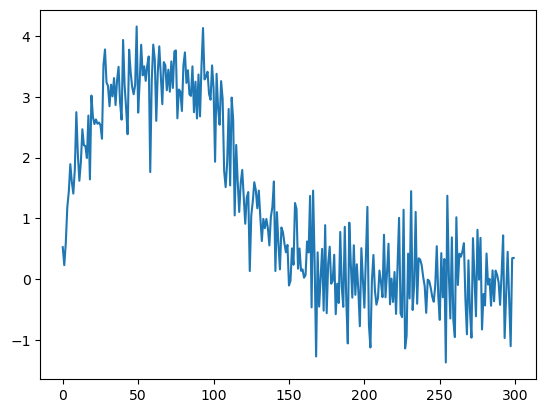

In [14]:
plt.plot(NBP_tszec)
#np.shape(T_tszec)

## Forward model


Lets start by assuming some of the constants



In [26]:
# time series of inputs
gpp=GPP_tszec 
T=T_tszec
rh=RH_tszec
nbp=NBP_tszec

# specify length of time series
yrs= np.arange(len(T))
dt=1

In [110]:
# specify initial conditions

# veg
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='cVeg', latrange='global')
MV0=timeseriesE.data[0]



# litter
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='cLitter', latrange='global')
ML0=timeseriesE.data[0]



# soil
timeseriesE=ds_C_global.sel(model=model, run='flat10', 
                               var='cSoil', latrange='global')
MS0=timeseriesE.data[0]



In [111]:
# integrate forward
# for i=2:length(tseries)
#     ML(i)=ML(i-1) + dt*(allocL*NPP(i) - ML(i-1)/tauL);
#     MR(i)=MR(i-1) + dt*(allocR*NPP(i) - MR(i-1)/tauR);
#     MW(i)=MW(i-1) + dt*(allocW*NPP(i) - MW(i-1)/tauW);
#     M2(i)=M2(i-1) + dt*(ML(i-1)/tauL + MR(i-1)/tauR - M2(i-1)/tau2); 
#     M3(i)=M3(i-1) + dt*(MW(i-1)/tauW - M3(i-1)/tau3);
#     M4(i)=M4(i-1) + dt*(gamma24*M2(i-1)/tau2 + gamma34*M3(i-1)/tau3 - M4(i-1)/tau4);
# end 


In [300]:
# assume constants

tauV= 15.6 # years
tauL= 1.0526 #1 # years 1/.95
tauS= 28

#fls/tauL
#flr = 1- 1/tauL #0.05
#fls = 1-flr #.95
#fsr =0.005

##beta= 1.5 # fertilization factor

##Q10c = 2 # respiration exponential

##fa = 0.5 # fracton of gpp that goes to autotrophic respiration or heterotropic respiration in less than 1 year

In [329]:
# Integrate forward

# Q10 factor is a fixed vector, can precompute
#Q10vec= np.power(Q10c,T/10)



# dMVdt= fa*gpp -MV/tauV
# dMLdt=MV/tauV - ML/tauL - ML*Q10vec
# dMSdt=ML/tauL - MS*Q10vec

# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
ML=np.empty(len(yrs))
ML[0]=ML0
MS=np.empty(len(yrs))
MS[0]=MS0
Q10=np.empty(len(yrs))
Q10[0]=np.nan
# NPP=np.empty(len(yrs))
# NPP[0]=np.nan

# NPP[y]=nbp[y] + rh[y] 
NPP=nbp+rh

flr = 1- 1/tauL 

for y in yrs[1:]:
    Q10[y]=np.exp(10/T[y]*np.log(rh[y]/(flr*ML[y-1]+(1/tauS)*MS[y-1])))
    
    MV[y]=MV[y-1] + dt*(NPP[y]-MV[y-1]/tauV)
    ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - flr*ML[y-1]*Q10[y])
    MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - (1/tauS)*MS[y-1]*Q10[y])
    
    # ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - ML[y-1]*Q10vec[y-1])
    # MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - MS[y-1]*Q10vec[y-1])
    



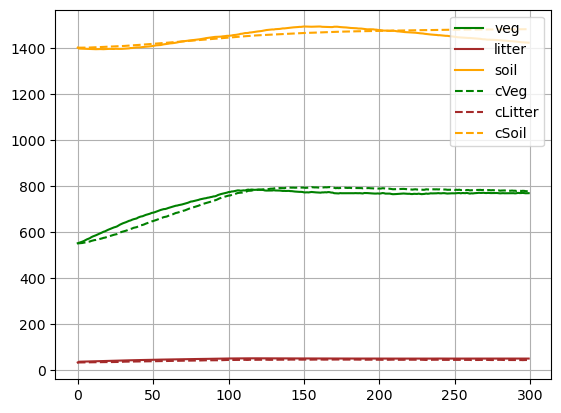

In [305]:
plt.plot(MV,label='veg',color='green')
plt.plot(ML,label='litter',color='brown')
plt.plot(MS,label='soil',color='orange')

plt.plot(cVeg_tszec,label='cVeg',linestyle='--',color='green')
plt.plot(cLitter_tszec,label='cLitter',linestyle='--',color='brown')
plt.plot(cSoil_tszec,label='cSoil',linestyle='--',color='orange') 

plt.title(f'Tuned by Hand Parameters: tauV={tauV:.2f}, tauL={tauL:.2f}, tauS={tauS:.2f}')

#plt.ylim([500, 800])

plt.grid()
plt.legend()

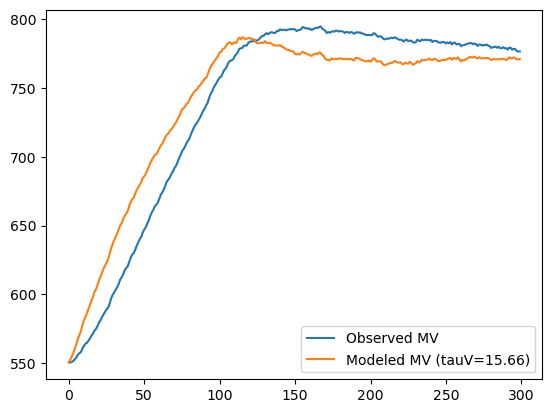

In [317]:
# Integrate forward

# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
ML=np.empty(len(yrs))
ML[0]=ML0
MS=np.empty(len(yrs))
MS[0]=MS0
Q10=np.empty(len(yrs))
Q10[0]=np.nan
NPP=nbp + rh

flr = 1- 1/tauL 

# for y in yrs[1:]:
#     #Q10[y]=np.exp(10/T[y]*np.log(rh[y]/(flr*ML[y-1]+(1/tauS)*MS[y-1])))
#     #NPP[y]=nbp[y] + rh[y] 
    
#     MV[y]=MV[y-1] + dt*(NPP[y]-MV[y-1]/tauV)
#     # ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - flr*ML[y-1]*Q10[y])
#     # MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - (1/tauS)*MS[y-1]*Q10[y])

# Jv=MV-cVeg_tszec

Mvobs=cVeg_tszec

# Simulation function
def simulate_MV(tauV, NPP, dt, MV0):
    MV = np.zeros_like(NPP)
    MV[0] = MV0
    for y in range(1, len(NPP)):
        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
    return MV

# Objective function to minimize (e.g. MSE)
def objective(tauV_array):
    tauV = tauV_array[0]  # Extract scalar from array
    if tauV <= 0:
        return np.inf
    MV = simulate_MV(tauV, NPP, dt, MV0)
    return np.mean((MV - Mvobs)**2)

# Initial guess and optimization
result = minimize(objective, x0=[10], bounds=[(1e-3, 1e3)])  # bounds to keep tauV > 0
tauV_opt = result.x[0]

# Final simulation with optimal tauV
MV_best = simulate_MV(tauV_opt, NPP, dt, MV0)

# Plotting (optional)
plt.plot(Mvobs, label='Observed MV')
plt.plot(MV_best, label=f'Modeled MV (tauV={tauV_opt:.2f})')
plt.legend()
plt.show()

In [ ]:
# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
ML=np.empty(len(yrs))
ML[0]=ML0
MS=np.empty(len(yrs))
MS[0]=MS0
Q10=np.empty(len(yrs))
Q10[0]=np.nan
# NPP=np.empty(len(yrs))
# NPP[0]=np.nan

# NPP[y]=nbp[y] + rh[y] 
NPP=nbp+rh


# Simulation function
def simulate_ML(tauL, NPP, dt, MV0):
    MV = np.zeros_like(NPP)
    MV[0] = MV0
    for y in range(1, len(NPP)):
        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
    return MV

# Objective function to minimize (e.g. MSE)
def objective(tauV_array):
    tauV = tauV_array[0]  # Extract scalar from array
    if tauV <= 0:
        return np.inf
    MV = simulate_MV(tauV, NPP, dt, MV0)
    return np.mean((MV - Mvobs)**2)

# Initial guess and optimization
result = minimize(objective, x0=[10], bounds=[(1e-3, 1e3)])  # bounds to keep tauV > 0
tauV_opt = result.x[0]

# Final simulation with optimal tauV
MV_best = simulate_MV(tauV_opt, NPP, dt, MV0)

# Plotting (optional)
plt.plot(Mvobs, label='Observed MV')
plt.plot(MV_best, label=f'Modeled MV (tauV={tauV_opt:.2f})')
plt.legend()
plt.show()

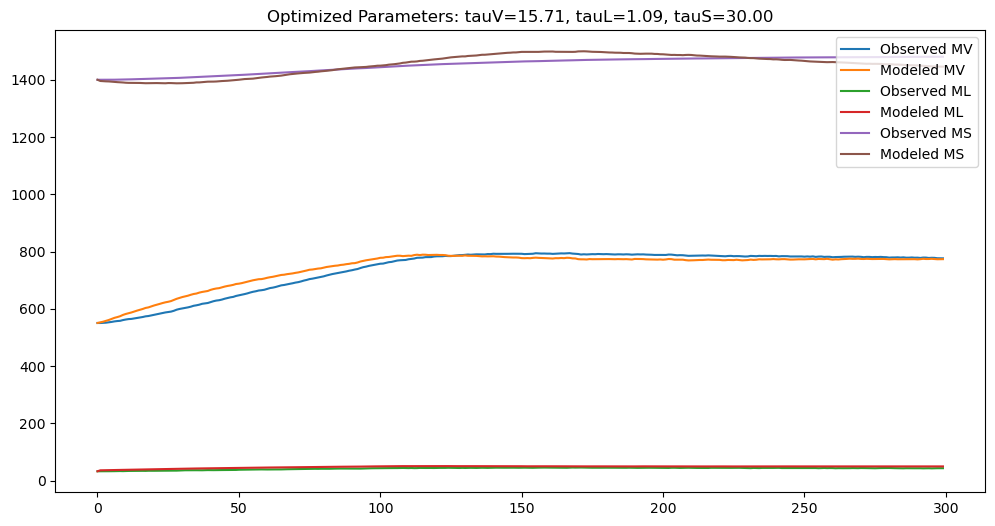

In [327]:
# initalize empty arrays
# MV=np.empty(len(yrs))
# MV[0]=MV0
# ML=np.empty(len(yrs))
# ML[0]=ML0
# MS=np.empty(len(yrs))
# MS[0]=MS0
# Q10=np.empty(len(yrs))
# Q10[0]=np.nan
# NPP=np.empty(len(yrs))
# NPP[0]=np.nan

# NPP[y]=nbp[y] + rh[y] 
NPP=nbp+rh


MV_obs=cVeg_tszec
ML_obs=cLitter_tszec
MS_obs=cSoil_tszec

# Simulation function
def simulate_model(tau_params):
    tauV, tauL, tauS = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    Q10 = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        denom = (1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}")
            return None
        Q10[y] = np.exp(10 / T[y] * np.log(rh[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 - 1 / tauL) * ML[y-1] * Q10[y]
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] * Q10[y]
        )

    return MV, ML, MS, Q10

# Objective function
def objective(tau_params):
    result = simulate_model(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    loss = (
        np.mean((MV - MV_obs) ** 2) +
        np.mean((ML - ML_obs) ** 2) +
        np.mean((MS - MS_obs) ** 2)
    )
    return loss

# Initial guess and bounds
initial_guess = [15.5, 1.0, 30.0]
bounds = [(1e-3, 1e3), (1e-3, 1e3), (1e-3, 1e3)]

# Run optimization
result = minimize(objective, x0=initial_guess, bounds=bounds)
tauV_opt, tauL_opt, tauS_opt = result.x

# Simulate with optimal parameters
MV_best, ML_best, MS_best, Q10_best = simulate_model(result.x)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(MV_obs, label='Observed MV')
plt.plot(MV_best, label=f'Modeled MV')
plt.plot(ML_obs, label='Observed ML')
plt.plot(ML_best, label='Modeled ML')
plt.plot(MS_obs, label='Observed MS')
plt.plot(MS_best, label='Modeled MS')
plt.legend()
plt.title(f'Optimized Parameters: tauV={tauV_opt:.2f}, tauL={tauL_opt:.2f}, tauS={tauS_opt:.2f}')
plt.show()

In [9]:
# initalize empty arrays
# MV=np.empty(len(yrs))
# MV[0]=MV0
# ML=np.empty(len(yrs))
# ML[0]=ML0
# MS=np.empty(len(yrs))
# MS[0]=MS0
# Q10=np.empty(len(yrs))
# Q10[0]=np.nan
# NPP=np.empty(len(yrs))
# NPP[0]=np.nan

# NPP[y]=nbp[y] + rh[y] 
NPP=nbp+rh


MV_obs=cVeg_tszec
ML_obs=cLitter_tszec
MS_obs=cSoil_tszec

# Simulation function
def simulate_model(tau_params):
    tauV, tauL, tauS = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    Q10 = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        denom = (1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}")
            return None
        Q10[y] = np.exp(10 / T[y] * np.log(rh[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 - 1 / tauL) * ML[y-1] * Q10[y]
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] * Q10[y]
        )

    return MV, ML, MS, Q10

# Objective function
def objective(tau_params):
    result = simulate_model(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    loss = (
        np.mean((MV - MV_obs) ** 2) +
        np.mean((ML - ML_obs) ** 2) +
        np.mean((MS - MS_obs) ** 2)
    )
    return loss

# Initial guess and bounds
initial_guess = [15.5, 1.0, 30.0]
bounds = [(1e-3, 1e3), (1.01, 1e3), (1e-3, 1e3)]

# Run optimization
result = minimize(objective, x0=initial_guess, bounds=bounds)
tauV_opt, tauL_opt, tauS_opt = result.x

# Simulate with optimal parameters
MV_best, ML_best, MS_best, Q10_best = simulate_model(result.x)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(MV_obs, label='Observed MV')
plt.plot(MV_best, label=f'Modeled MV')
plt.plot(ML_obs, label='Observed ML')
plt.plot(ML_best, label='Modeled ML')
plt.plot(MS_obs, label='Observed MS')
plt.plot(MS_best, label='Modeled MS')
plt.legend()
plt.title(f'Optimized Parameters: tauV={tauV_opt:.2f}, tauL={tauL_opt:.2f}, tauS={tauS_opt:.2f}')
plt.show()

NameError: name 'nbp' is not defined

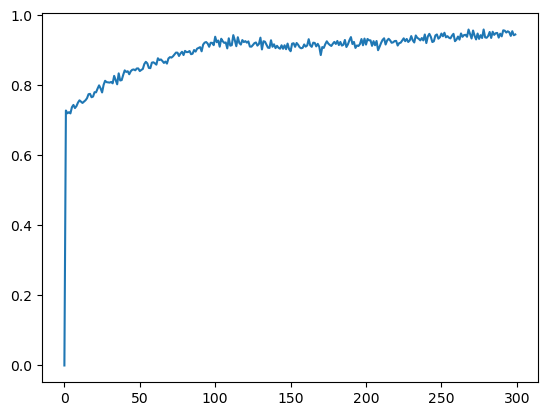

In [328]:
plt.plot(Q10_best)

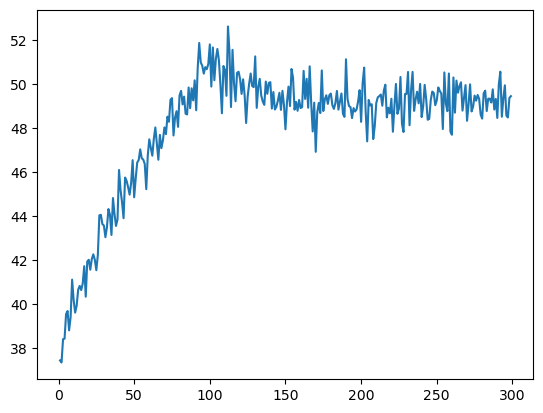

In [307]:
plt.plot(NPP)

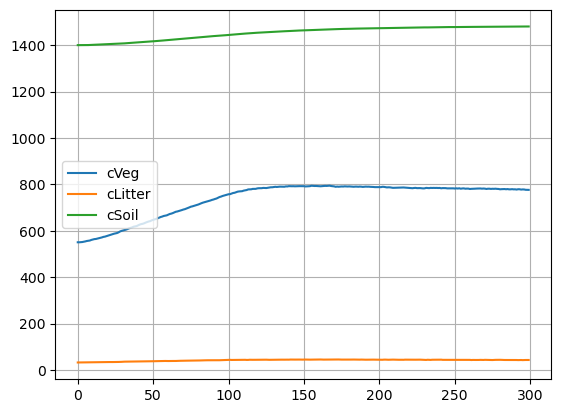

In [117]:
plt.plot(cVeg_tszec,label='cVeg')
plt.plot(cLitter_tszec,label='cLitter')
plt.plot(cVeg_tszec,label='cSoil')
plt.legend()

In [13]:
def get_full_ts_flat10(modelname, exp, var, latrange):

    '''
    inputs (modelname, exp, var, latrange)
    outputs (VAR_ts) 
    
    # unit conversions need to be made after this is called
    # GPP_ts= GPP *  speryr #convert from Pg/s to Pg/yr
    # T_tszec = T-273.15
    # RH_tszec= RH *  speryr #convert from Pg/s to Pg/yr
    # NBP_tszec= NBP *  speryr #convert from Pg/s to Pg/yr
    
    '''
    timeseriesE=ds_C_global.sel(model=modelname, run='flat10', 
                                   var=var, latrange=latrange)
    
    timeseries=ds_C_global.sel(model=modelname, run=exp, 
                                   var=var, latrange=latrange)
    
    VAR_ts=np.append(timeseriesE.data[0:100].values, timeseries.data[0:200].values) 
    
    return VAR_ts


In [128]:
## - this is the box model!

# Simulation function
def simulate_model(tau_params):
    tauV, tauL, tauS = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    Q10 = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        
        denom = (1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},tauL={tauL},tauS={tauS}")
            return None
        Q10[y] = np.exp(10 / T[y] * np.log(RH[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 - 1 / tauL) * ML[y-1] * Q10[y]**(T[y]/10)
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] * Q10[y]**(T[y]/10)
        )

    return MV, ML, MS, Q10

# Objective function
def objective(tau_params):
    result = simulate_model(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 2.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 217.64354897770167
        x: [ 1.507e+01  2.119e+00  3.714e+01]
      nit: 21
      jac: [-3.553e-02 -5.701e-03  1.705e-04]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


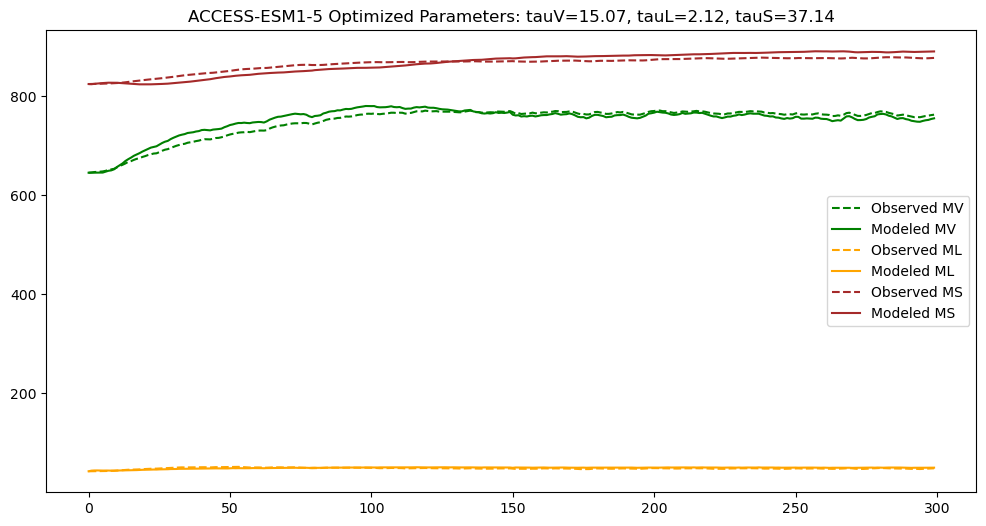

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2120.2652775043207
        x: [ 1.599e+01  1.027e+00  1.000e+00]
      nit: 24
      jac: [ 4.957e-03  4.775e-03  6.330e-02]
     nfev: 148
     njev: 37
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


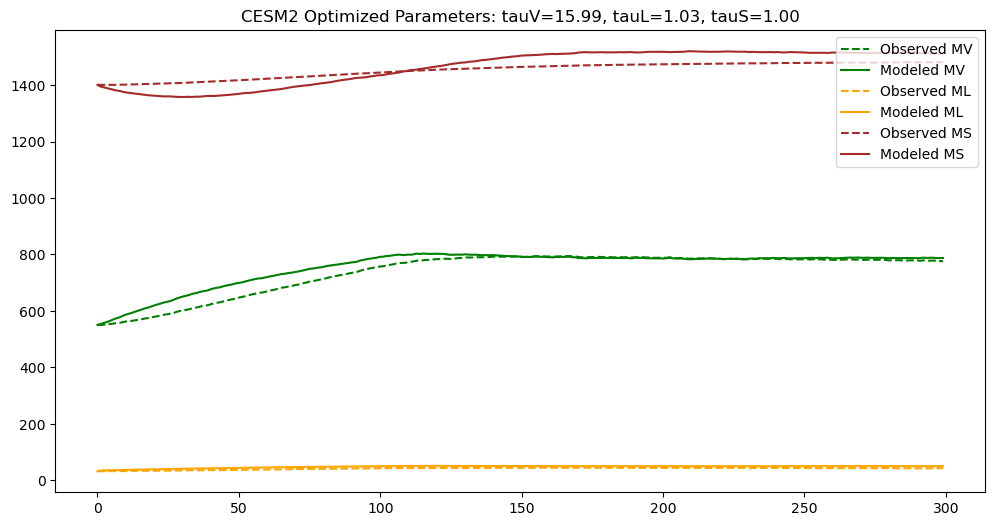

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1956.079911056515
        x: [ 9.572e+00  2.000e+02  5.102e+01]
      nit: 23
      jac: [ 9.186e-03 -3.083e+00 -1.137e-04]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


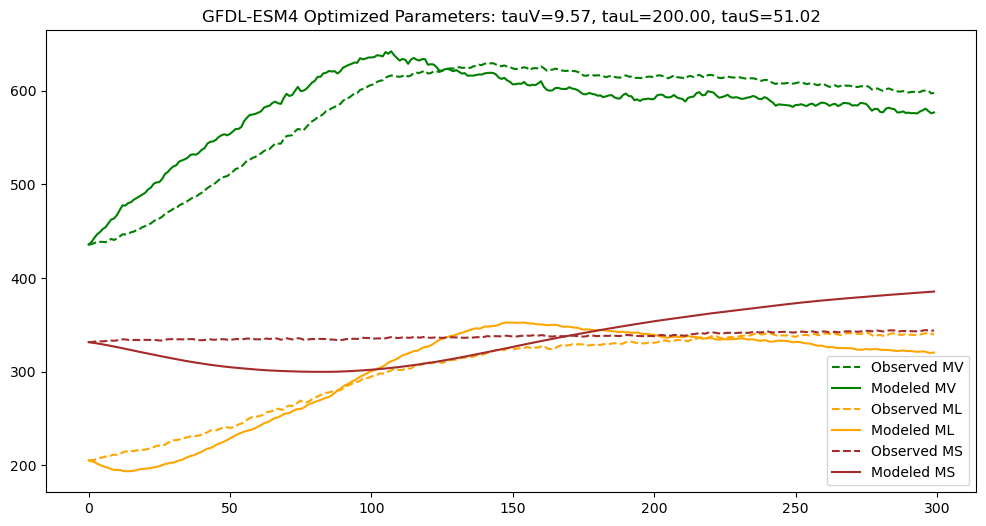

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1832.577652471499
        x: [ 1.614e+01  1.010e+00  1.800e+02]
      nit: 21
      jac: [-3.108e-01  1.069e+02  1.887e-03]
     nfev: 188
     njev: 47
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


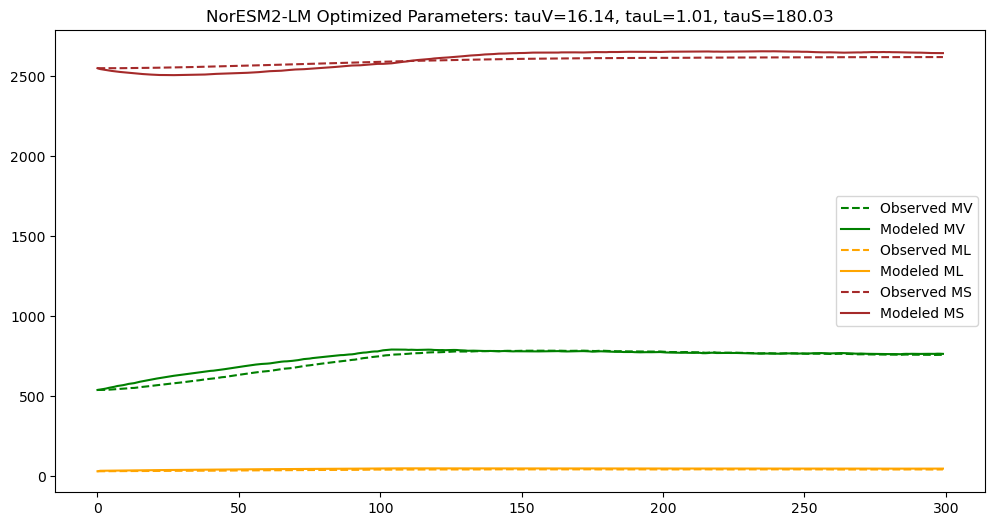

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1834.185931484209
        x: [ 7.581e+00  1.356e+01  5.224e+00]
      nit: 43
      jac: [-2.274e-04 -1.364e-04  5.048e-03]
     nfev: 220
     njev: 55
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


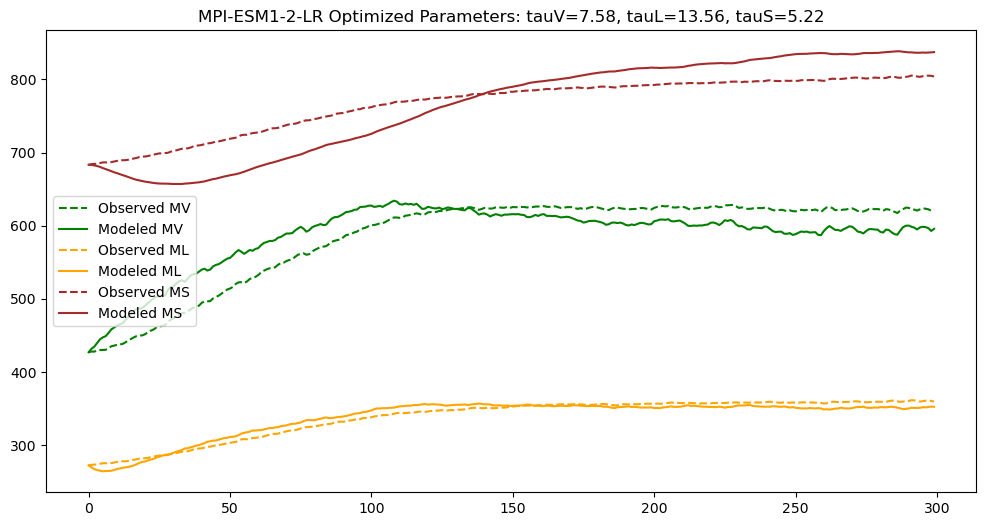

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2055.2332302551613
        x: [ 1.582e+01  9.677e+00  4.267e+00]
      nit: 23
      jac: [-7.913e-03 -5.912e-03  2.365e-03]
     nfev: 124
     njev: 31
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


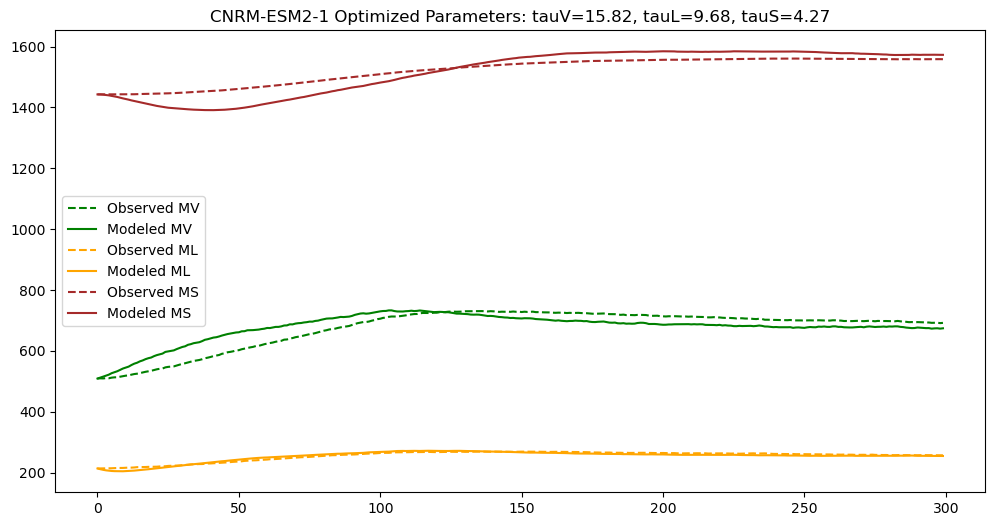

In [129]:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            #'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1']#,
            #'HadCM3LC-Bris',
            #'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year

# initialize some empty arrays to store outputs
tauV_vec=np.empty(len(modellist))
tauL_vec=np.empty(len(modellist))
tauS_vec=np.empty(len(modellist))
Q10_mat=np.empty([len(modellist),300])

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition

    if np.isnan(ML_obs).any():
        print('no litter')

    
    #--- GPP
    GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-298.15 #baseline temp is 25C
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH
    
    # Initial guess and bounds
    initial_guess = [20,20,20]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1, 8e2), (1.01, 2e2), (1, 8e2)]
    
    # Run optimization
    result = minimize(objective, x0=initial_guess, bounds=bounds)
    tauV_opt, tauL_opt, tauS_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, ML_best, MS_best, Q10_best = simulate_model(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
    plt.plot(ML_best, label='Modeled ML',color='orange')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={tauV_opt:.2f}, tauL={tauL_opt:.2f}, tauS={tauS_opt:.2f}')
    plt.show()

    tauV_vec[m]=tauV_opt
    tauL_vec[m]=tauL_opt
    tauS_vec[m]=tauS_opt
    Q10_mat[m,:]=Q10_best
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    

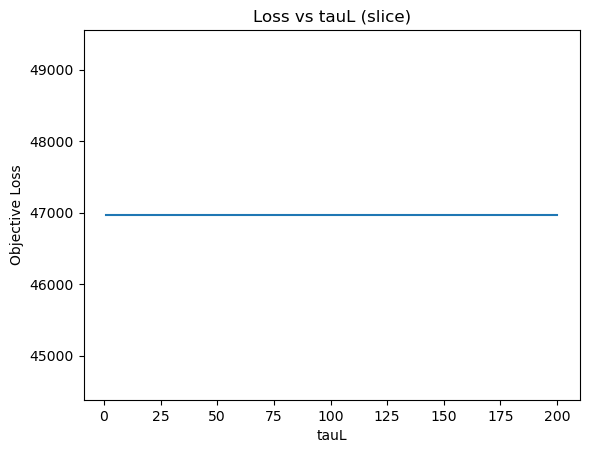

In [95]:
tauL_range = np.linspace(1, 200, 100)
loss_vals = []

for tauV in tauV_range:
    loss = objective([tauV_opt, tauL, tauS_opt])  # fix others
    loss_vals.append(loss)

plt.plot(tauL_range, loss_vals)
plt.xlabel('tauL')
plt.ylabel('Objective Loss')
plt.title('Loss vs tauL (slice)')
plt.show()

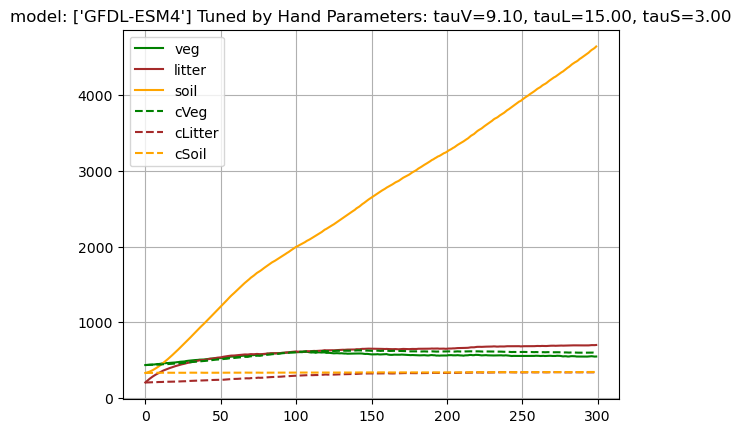

In [42]:
## One model by hand

model=['GFDL-ESM4']

# assume constants

tauV= 9.1 # years
tauL= 15 #1 # years 1/.95
tauS= 3



#--- cLitter
cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
ML_obs= cLitter
ML0=ML_obs[0] #specify initial condition

if np.isnan(ML_obs).any():
    print('no litter')


#--- GPP
GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
GPP= GPPo *  speryr #convert from Pg/s to Pg/yr

#--- TAS    
To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
T = To-273.15

#--- RH
RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
RH= RHo *  speryr #convert from Pg/s to Pg/yr

#--- NBP
NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

#--- cVeg  
cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
MV_obs= cVeg 
MV0=MV_obs[0]

#--- cSoil
cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
MS_obs= cSoil 
MS0=MS_obs[0] # specify initial condition


# calculate NPP from nbp and rh 
NPP=NBP + RH

# specify length of time series
yrs= np.arange(len(T))

# Integrate forward

# Q10 factor is a fixed vector, can precompute
#Q10vec= np.power(Q10c,T/10)



# dMVdt= fa*gpp -MV/tauV
# dMLdt=MV/tauV - ML/tauL - ML*Q10vec
# dMSdt=ML/tauL - MS*Q10vec

# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
ML=np.empty(len(yrs))
ML[0]=ML0
MS=np.empty(len(yrs))
MS[0]=MS0
Q10=np.empty(len(yrs))
Q10[0]=np.nan
# NPP=np.empty(len(yrs))
# NPP[0]=np.nan


flr = 1- 1/tauL 

for y in yrs[1:]:
    Q10[y]=np.exp(10/T[y]*np.log(RH[y]/(flr*ML[y-1]+(1/tauS)*MS[y-1])))
    
    MV[y]=MV[y-1] + dt*(NPP[y]-MV[y-1]/tauV)
    ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - flr*ML[y-1]*Q10[y])
    MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - (1/tauS)*MS[y-1]*Q10[y])
    
    # ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - ML[y-1]*Q10vec[y-1])
    # MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - MS[y-1]*Q10vec[y-1])
    



plt.plot(MV,label='veg',color='green')
plt.plot(ML,label='litter',color='brown')
plt.plot(MS,label='soil',color='orange')

plt.plot(MV_obs,label='cVeg',linestyle='--',color='green')
plt.plot(ML_obs,label='cLitter',linestyle='--',color='brown')
plt.plot(MS_obs,label='cSoil',linestyle='--',color='orange') 

plt.title(f'model: {model} Tuned by Hand Parameters: tauV={tauV:.2f}, tauL={tauL:.2f}, tauS={tauS:.2f}')

#plt.ylim([500, 800])

plt.grid()
plt.legend()


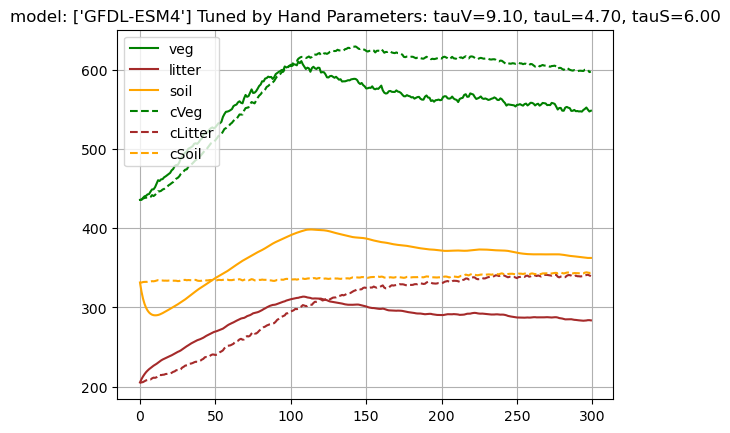

In [92]:
## One model by hand no Q10

model=['GFDL-ESM4']

# assume constants

tauV= 9.1 # years
tauL= 4.7 #1 # years 1/.95
tauS= 6



#--- cLitter
cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
ML_obs= cLitter
ML0=ML_obs[0] #specify initial condition

if np.isnan(ML_obs).any():
    print('no litter')


#--- GPP
GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
GPP= GPPo *  speryr #convert from Pg/s to Pg/yr

#--- TAS    
To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
T = To-298.15

#--- RH
RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
RH= RHo *  speryr #convert from Pg/s to Pg/yr

#--- NBP
NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

#--- cVeg  
cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
MV_obs= cVeg 
MV0=MV_obs[0]

#--- cSoil
cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
MS_obs= cSoil 
MS0=MS_obs[0] # specify initial condition


# calculate NPP from nbp and rh 
NPP=NBP + RH

# specify length of time series
yrs= np.arange(len(T))

# Integrate forward

# Q10 factor is a fixed vector, can precompute
#Q10vec= np.power(Q10c,T/10)



# dMVdt= fa*gpp -MV/tauV
# dMLdt=MV/tauV - ML/tauL - ML*Q10vec
# dMSdt=ML/tauL - MS*Q10vec

# initalize empty arrays
MV=np.empty(len(yrs))
MV[0]=MV0
ML=np.empty(len(yrs))
ML[0]=ML0
MS=np.empty(len(yrs))
MS[0]=MS0
Q10=np.empty(len(yrs))
Q10[0]=np.nan
# NPP=np.empty(len(yrs))
# NPP[0]=np.nan


flr = 1- 1/tauL 

for y in yrs[1:]:
   # Q10[y]=np.exp(10/T[y]*np.log(RH[y]/(flr*ML[y-1]+(1/tauS)*MS[y-1])))
    
    MV[y]=MV[y-1] + dt*(NPP[y]-MV[y-1]/tauV)
    ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL)
    MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - (1/tauS)*MS[y-1])
    # ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - flr*ML[y-1]*Q10[y])
    # MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - (1/tauS)*MS[y-1]*Q10[y])
    
    # ML[y]=ML[y-1] + dt*(MV[y-1]/tauV - ML[y-1]/tauL - ML[y-1]*Q10vec[y-1])
    # MS[y]=MS[y-1] + dt*(ML[y-1]/tauL - MS[y-1]*Q10vec[y-1])
    



plt.plot(MV,label='veg',color='green')
plt.plot(ML,label='litter',color='brown')
plt.plot(MS,label='soil',color='orange')

plt.plot(MV_obs,label='cVeg',linestyle='--',color='green')
plt.plot(ML_obs,label='cLitter',linestyle='--',color='brown')
plt.plot(MS_obs,label='cSoil',linestyle='--',color='orange') 

plt.title(f'model: {model} Tuned by Hand Parameters: tauV={tauV:.2f}, tauL={tauL:.2f}, tauS={tauS:.2f}')

#plt.ylim([500, 800])

plt.grid()
plt.legend()


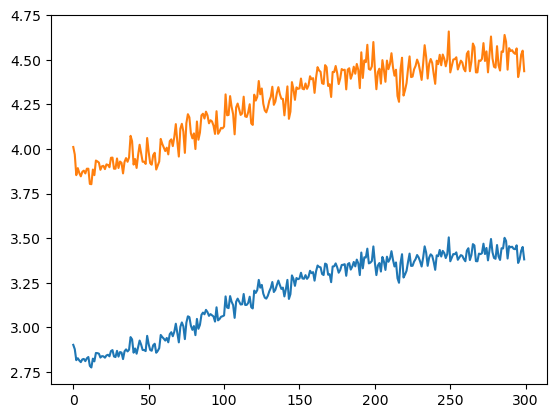

In [91]:
# lets try estimating Q10 from the pools themselves by assuming tau


# model=['CESM2']

# # assume constants
# tauV= 15.7 # years
# tauL= 1.09 #1 # years 1/.95
# tauS= 30

model=['GFDL-ESM4']
# assume constants
tauV= 9.1 # years
tauL= 10 #1 # years 1/.95
tauS= 3

#--- cLitter
cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
ML_obs= cLitter
ML0=ML_obs[0] #specify initial condition

if np.isnan(ML_obs).any():
    print('no litter')


#--- GPP
GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
GPP= GPPo *  speryr #convert from Pg/s to Pg/yr

#--- TAS    
To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
T = To-298.15

#--- RH
RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
RH= RHo *  speryr #convert from Pg/s to Pg/yr

#--- NBP
NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

#--- cVeg  
cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
MV_obs= cVeg 
MV0=MV_obs[0]

#--- cSoil
cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
MS_obs= cSoil 
MS0=MS_obs[0] # specify initial condition


Q10_est=np.exp(10/T*np.log(RH/((1-1/tauL)*ML_obs+(1/tauS)*MS_obs)))

Q10_est2=np.exp(10/T*np.log(RH/((1-1/tauL)*ML_obs+MS_obs)))


plt.plot(Q10_est)
plt.plot(Q10_est2)

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 106.96881243904298
        x: [ 1.503e+01]
      nit: 3
      jac: [ 2.402e-04]
     nfev: 10
     njev: 5
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


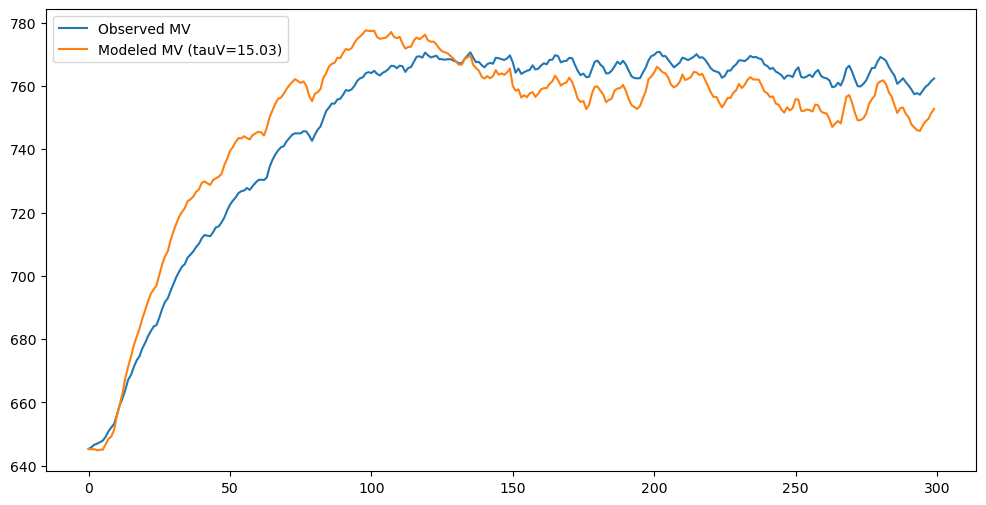

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 457.8125053003708
        x: [ 1.566e+01]
      nit: 3
      jac: [-2.274e-05]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


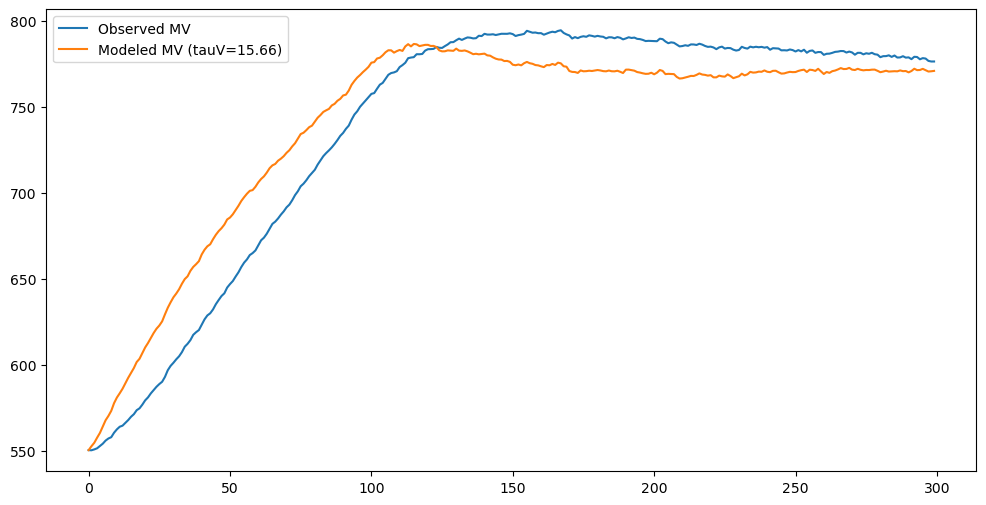

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 770.5339059473747
        x: [ 9.543e+00]
      nit: 4
      jac: [-2.842e-04]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


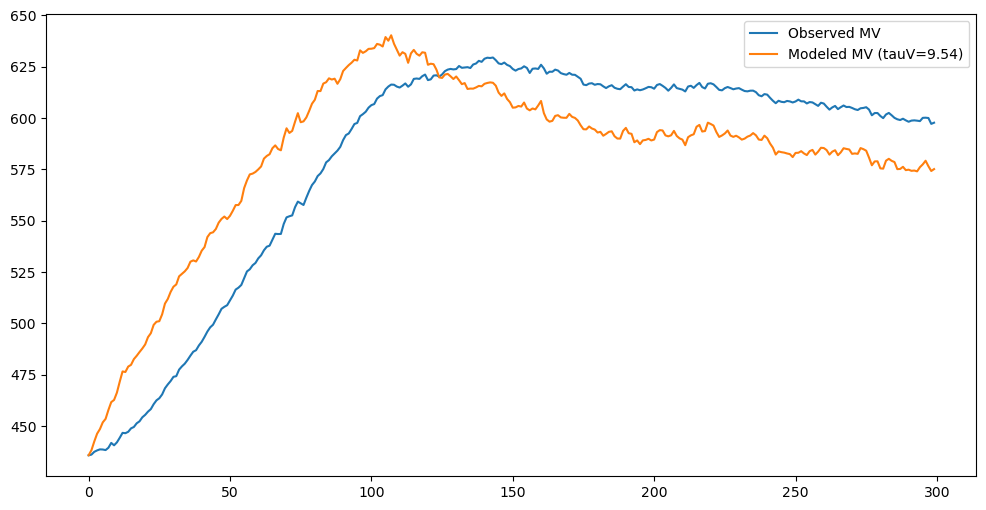

estimating parameters for model: GISS_E2.1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 507.1414662524183
        x: [ 1.580e+01]
      nit: 3
      jac: [-1.137e-05]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


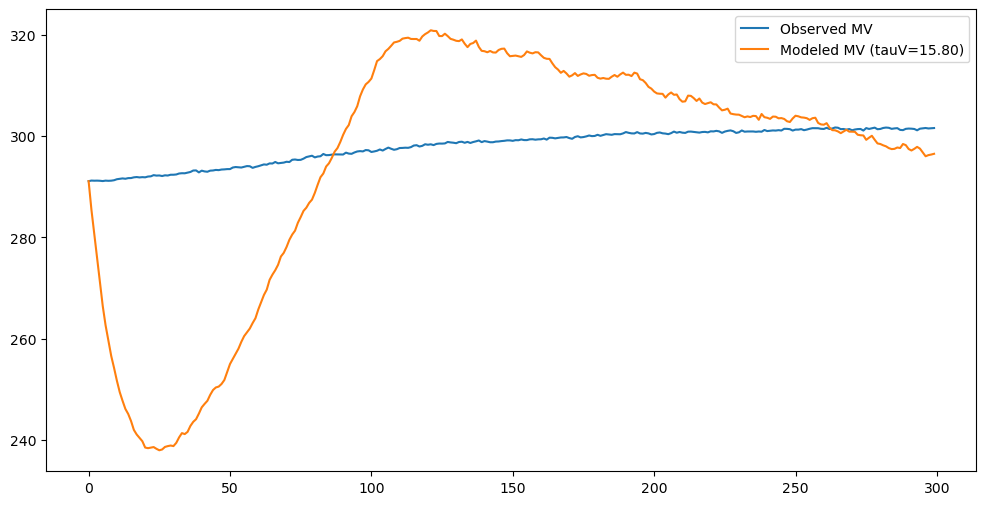

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 457.01231996031544
        x: [ 1.585e+01]
      nit: 3
      jac: [-1.023e-04]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


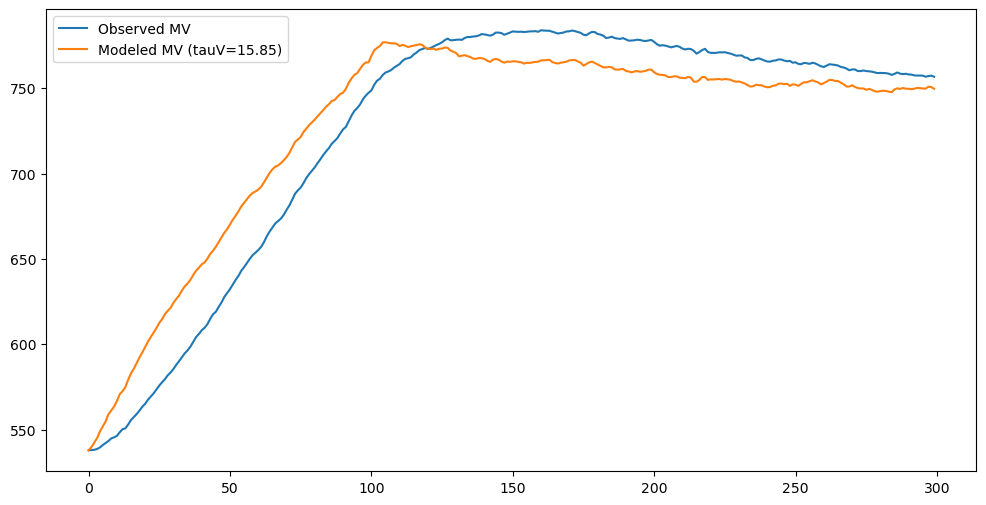

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 744.0955863981452
        x: [ 7.584e+00]
      nit: 5
      jac: [ 0.000e+00]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


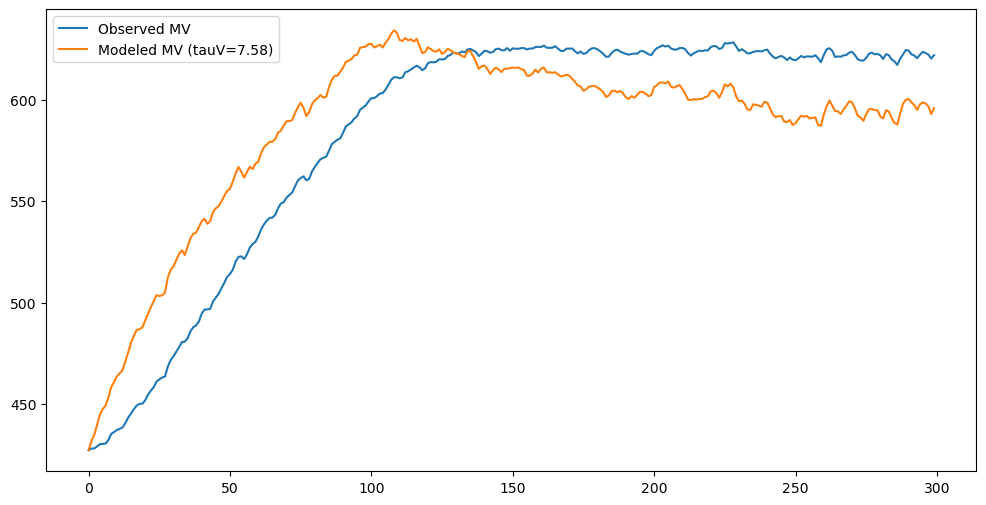

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 984.8094426985193
        x: [ 1.583e+01]
      nit: 3
      jac: [ 6.594e-04]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


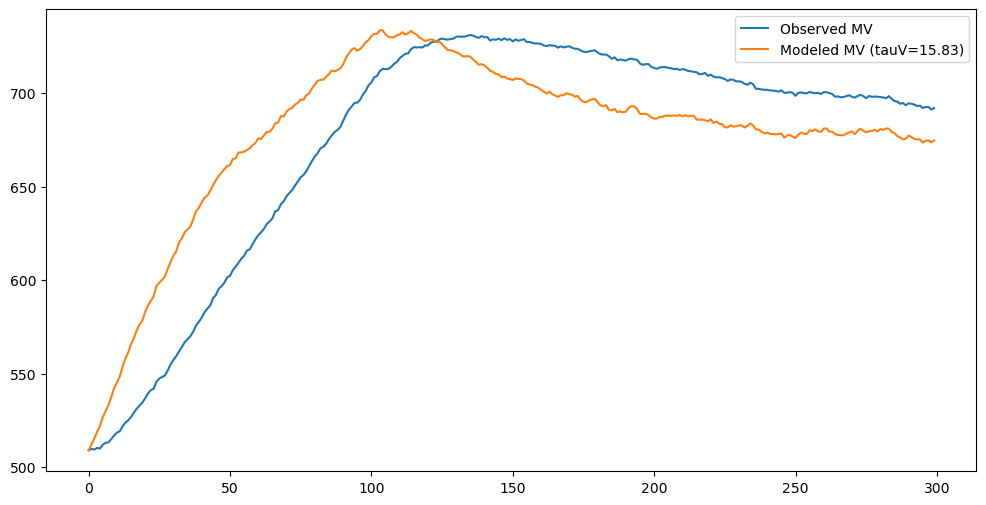

estimating parameters for model: HadCM3LC-Bris
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 700.7053609116998
        x: [ 8.605e+00]
      nit: 4
      jac: [-3.183e-04]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


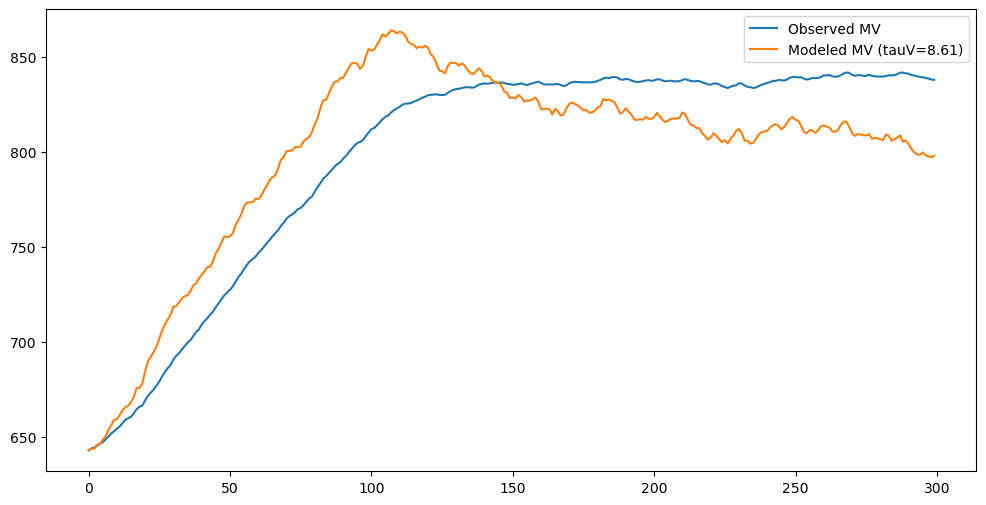

estimating parameters for model: UKESM1.2
simulate_MV returned NaNs for tauV=15.0
simulate_MV returned NaNs for tauV=15.00000001
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV returned NaNs for tauV=nan
simulate_MV r

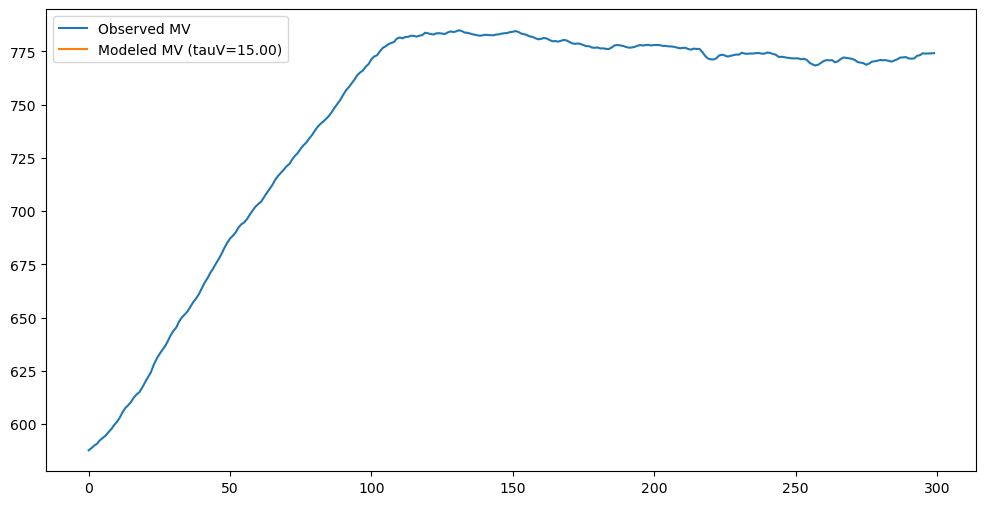

In [86]:
# Simulation function
def simulate_MV(tauV, NPP, dt, MV0):
    MV = np.zeros_like(NPP)
    MV[0] = MV0
    for y in range(1, len(NPP)):
        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
    return MV

# # Objective function to minimize (e.g. MSE)
# def objective_MV(tauV_array):
#     tauV = tauV_array[0]  # Extract scalar from array
#     if tauV <= 0:
#         return np.inf
#     MV = simulate_MV(tauV, NPP, dt, MV0)
#     return np.mean((MV - MV_obs)**2)

def objective_MV(tauV_array):
    tauV = tauV_array[0]
    if tauV <= 0:
        return np.inf

    MV = simulate_MV(tauV, NPP, dt, MV0)

    if np.any(np.isnan(MV)) or np.any(np.isinf(MV)):
        print(f"simulate_MV returned NaNs for tauV={tauV}")
        return np.inf

    loss = np.mean((MV - MV_obs)**2)

    if np.isnan(loss) or np.isinf(loss):
        print(f"Loss is NaN or inf for tauV={tauV}")
        return np.inf

    return loss

latrange='global'
dt=1 # timestep is 1 year
modellist=modellist_orig

# initialize some empty arrays to store outputs
tauVonly_vec=np.empty(len(modellist))


for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

     
    #--- GPP

    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    


    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH
    
    # Initial guess and bounds
   
    # Run optimization
    result = minimize(objective_MV, x0=[15], bounds=[(1, 1e3)])  # bounds to keep tauV > 0
    tauV_opt = result.x[0]
    print("Optimization Result:", result)
    
    # Final simulation with optimal tauV
    MV_best = simulate_MV(tauV_opt, NPP, dt, MV0)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV')
    plt.plot(MV_best, label=f'Modeled MV (tauV={tauV_opt:.2f})')

    plt.legend()
    plt.show()

    tauVonly_vec[m]=tauV_opt

    


Model: GFDL-ESM4
MV0: 435.76182542675923
MV_obs has NaN? False
NPP has NaN? False
MV_obs range: 435.76182542675923 629.4503038230068
NPP range: 46.67252178781181 71.11924219001766


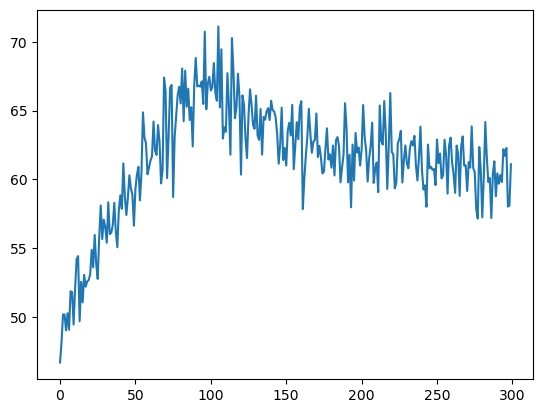

In [84]:
model='GFDL-ESM4'

#--- RH
RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
RH= RHo *  speryr #convert from Pg/s to Pg/yr

#--- NBP
NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
NBP= NBPo *  speryr #convert from Pg/s to Pg/yr

NPP=NBP+RH

plt.plot(NPP)

if np.any(np.isnan(NBP)):
    print('NBP has nan')


if np.any(np.isnan(RH)):
    print('RH has nan')


#--- cVeg  
cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
MV_obs= cVeg 
MV0=MV_obs[0]


if np.any(np.isnan(MV_obs)):
    print('cVeg has nan')


print(f"Model: {model}")
print("MV0:", MV0)
print("MV_obs has NaN?", np.any(np.isnan(MV_obs)))
print("NPP has NaN?", np.any(np.isnan(NPP)))
print("MV_obs range:", np.nanmin(MV_obs), np.nanmax(MV_obs))
print("NPP range:", np.nanmin(NPP), np.nanmax(NPP))

In [109]:
## - this is the box model! - TWO BOXES ONLY

# Simulation function
def simulate_model_2Box(tau_params):
    tauV, tauS = tau_params
    if tauV <= 0 or tauS <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    MS = np.zeros(n)
    Q10 = np.zeros(n)

    MV[0], MS[0] = MV0, MS0

    for y in range(1, n):
        MS[y-1] = max(MS[y-1], 1e-6)
        
        denom = (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}, MS[y-1]={MS[y-1]},tauS={tauS}")
            return None
        Q10[y] = np.exp(10 / T[y] * np.log(RH[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        MS[y] = MS[y-1] + dt * (
            MV[y-1] / tauV - (1 / tauS) * MS[y-1] * Q10[y]
        )

    return MV, MS, Q10

# Objective function
def objective_2Box(tau_params):
    result = simulate_model_2Box(tau_params)
    if result is None:
        return np.inf
    MV, MS, Q10 = result
    # Mean squared error across all three time series
    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((MS - MS_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 545.3936752956964
        x: [ 1.500e+01  1.838e+01]
      nit: 6
      jac: [-1.819e-04 -1.478e-04]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


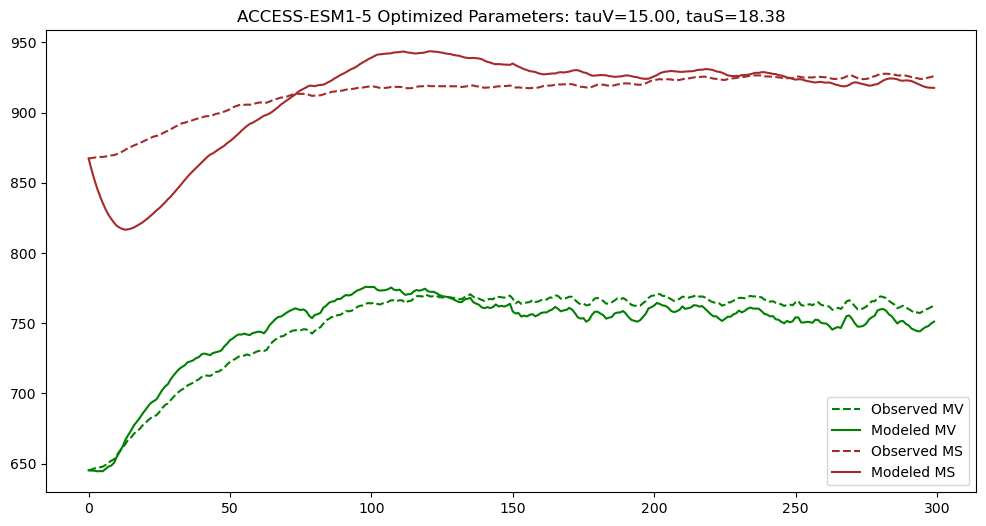

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 6207.120988509108
        x: [ 1.548e+01  3.165e+01]
      nit: 6
      jac: [ 1.819e-03 -9.095e-05]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


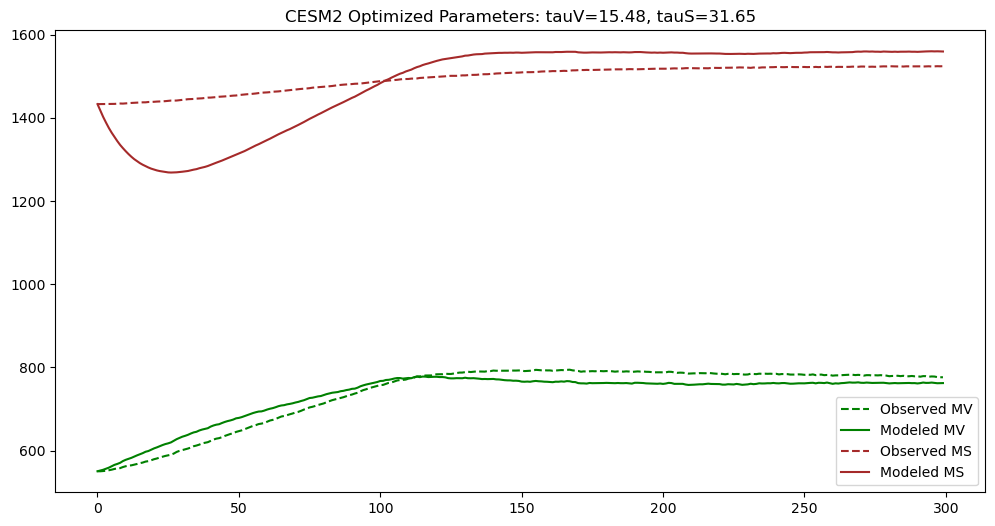

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1819.307108731111
        x: [ 9.539e+00  1.053e+01]
      nit: 5
      jac: [-1.410e-03 -3.183e-03]
     nfev: 21
     njev: 7
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


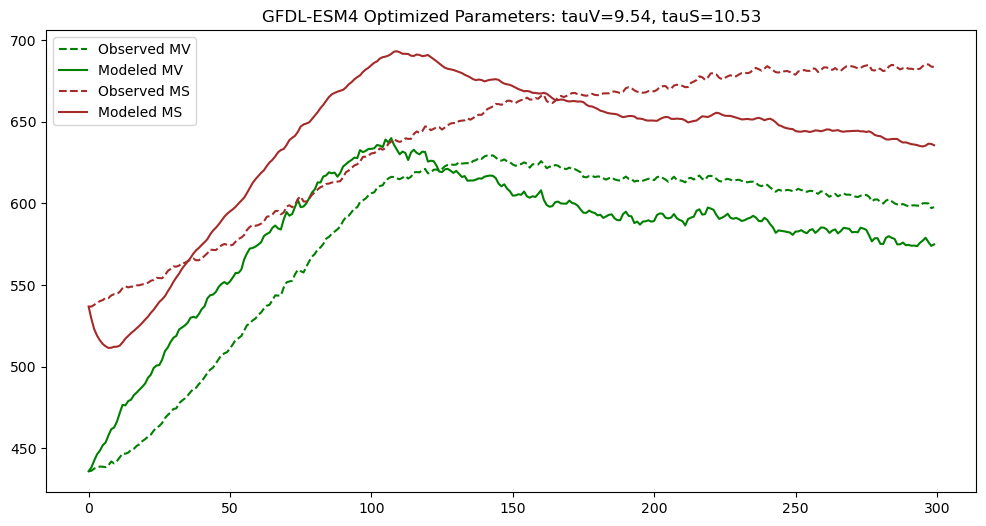

estimating parameters for model: GISS_E2.1
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=20.0
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=20.0
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=20.00000001
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-15.596926810692082, MS[y-1]=nan,tauS=nan
Invalid Q10 input at st

TypeError: cannot unpack non-iterable NoneType object

In [121]:
# 2 box model
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year
Tb=298.15 # baseline temp for respiration Q10

# initialize some empty arrays to store outputs
tauV_vec=np.empty(len(modellist))
tauS_vec=np.empty(len(modellist))
Q10_mat=np.empty([len(modellist),300])

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output     
    # --- GPP
    # GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    # GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-Tb # remove baseline temp 
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)

    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    
    if np.any(np.isnan(ML_obs)):
        print('no litter')
        MS_obs= cSoil 
    else: # litter exists
        MS_obs= cSoil + cLitter
    
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH
    
    # Initial guess and bounds
    initial_guess = [20,20]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1, 8e2),  (1, 8e2)]
    
    # Run optimization
    result = minimize(objective_2Box, x0=initial_guess, bounds=bounds)
    tauV_opt, tauS_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, MS_best, Q10_best = simulate_model_2Box(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={tauV_opt:.2f}, tauS={tauS_opt:.2f}')
    plt.show()

    tauV_vec[m]=tauV_opt
    tauS_vec[m]=tauS_opt
    Q10_mat[m,:]=Q10_best
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    

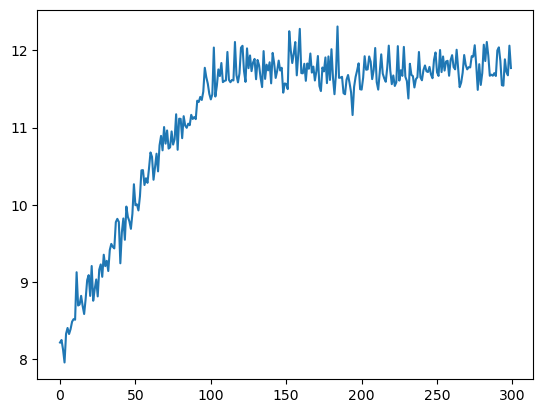

In [119]:
plt.plot(To-273.15)

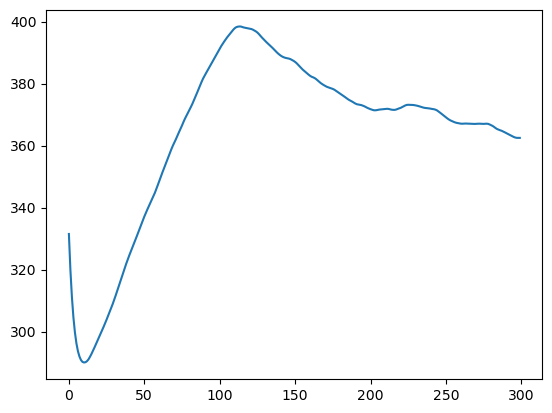

In [122]:
plt.plot(MS)

In [130]:
## - this is the box model!

## 3 box model


# Simulation function
def simulate_model(tau_params):
    tauV, tauL, tauS = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    Q10 = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        
        denom = (1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},tauL={tauL},tauS={tauS}")
            return None
        Q10[y] = np.exp(10 / T[y] * np.log(RH[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 - 1 / tauL) * ML[y-1] * Q10[y]**(T[y]/10)
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] * Q10[y]**(T[y]/10)
        )

    return MV, ML, MS, Q10

# Objective function
def objective(tau_params):
    result = simulate_model(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 2.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 1.0
    )
    return loss

In [136]:
## - this is the box model!

# 3 Box model, constant Q10

# Simulation function
def simulate_model_3box_cnstQ10(tau_params):
    tauV, tauL, tauS, Q10 = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0 or Q10 <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        
        denom = (1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},tauL={tauL},tauS={tauS}")
            return None
        RH = ((1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1])*np.exp((T[y]/10)*np.log(Q10))
        ##Q10[y] = np.exp(10 / T[y] * np.log(RH[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 - 1 / tauL) * ML[y-1] * Q10**(T[y]/10)
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] * Q10**(T[y]/10)
        )

    return MV, ML, MS, Q10

# Objective function
def objective_3box_cnstQ10(tau_params):
    result = simulate_model_3box_cnstQ10(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 2.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 1.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 354.02354319943754
        x: [ 1.502e+01  8.342e+00  1.342e+02  1.041e+00]
      nit: 25
      jac: [-3.041e-02 -8.527e-05  2.109e-03  1.837e-01]
     nfev: 170
     njev: 34
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


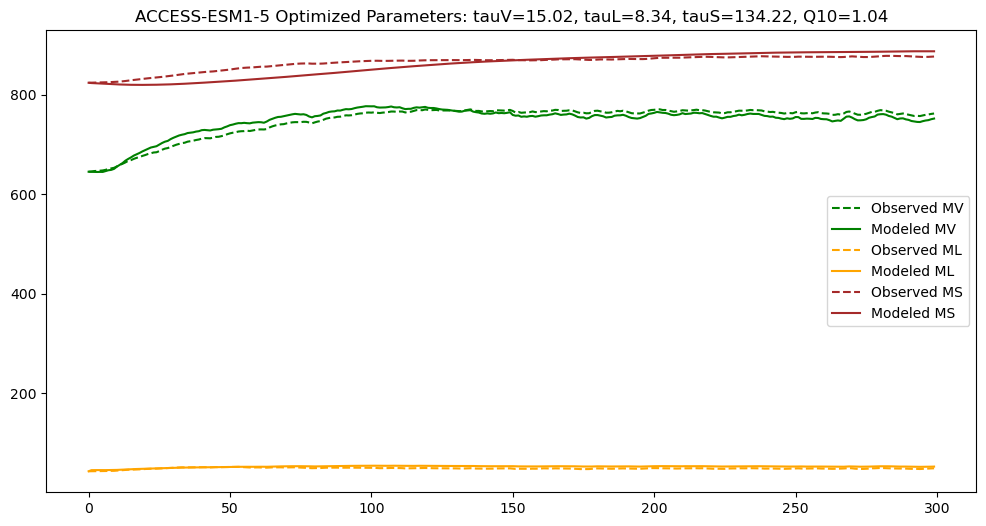

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 721.0610579223612
        x: [ 1.565e+01  2.283e+01  1.000e+03  9.472e-01]
      nit: 51
      jac: [-1.330e-03 -1.285e-03 -1.485e-01  4.670e-02]
     nfev: 335
     njev: 67
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


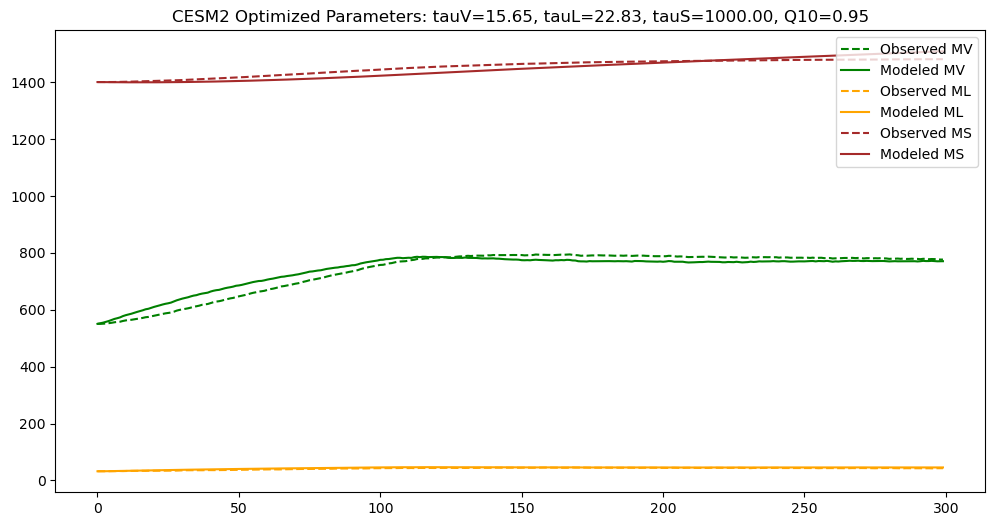

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3845.087403075663
        x: [ 9.577e+00  8.904e+00  1.000e+00  4.241e+00]
      nit: 51
      jac: [ 2.728e-04  2.274e-04  2.867e+02  5.275e-03]
     nfev: 385
     njev: 77
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


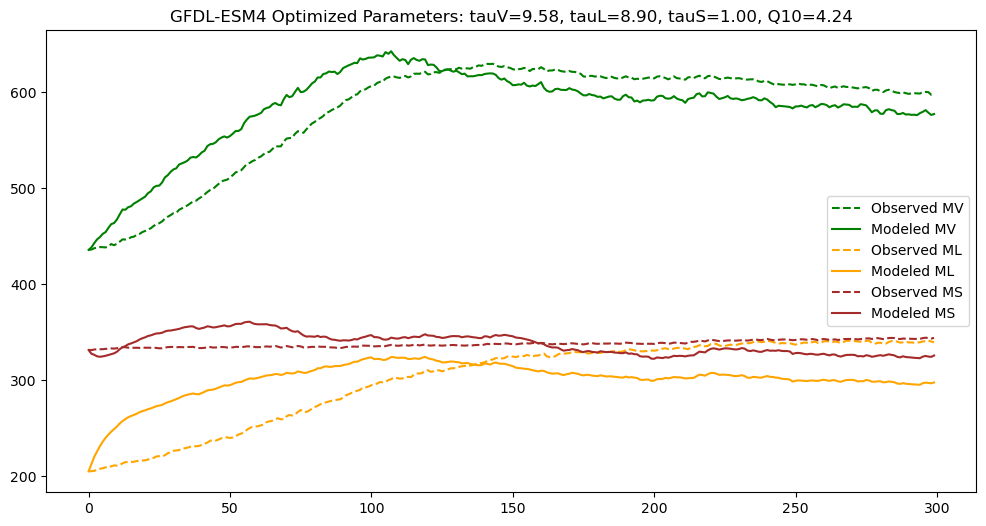

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 922.5655316544548
        x: [ 1.584e+01  1.404e+01  1.000e+03  9.591e-01]
      nit: 66
      jac: [-4.241e-03 -1.968e-02 -4.375e-01  6.550e-01]
     nfev: 405
     njev: 81
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


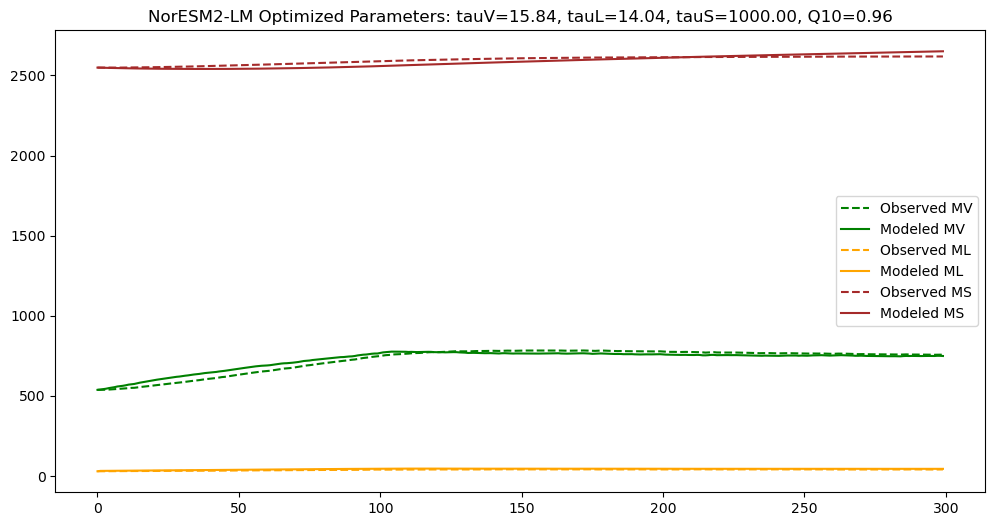

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2408.9774310013563
        x: [ 7.592e+00  3.804e+01  1.878e+01  2.719e+00]
      nit: 45
      jac: [ 1.028e-02 -4.093e-04  1.273e-03  1.273e-02]
     nfev: 310
     njev: 62
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


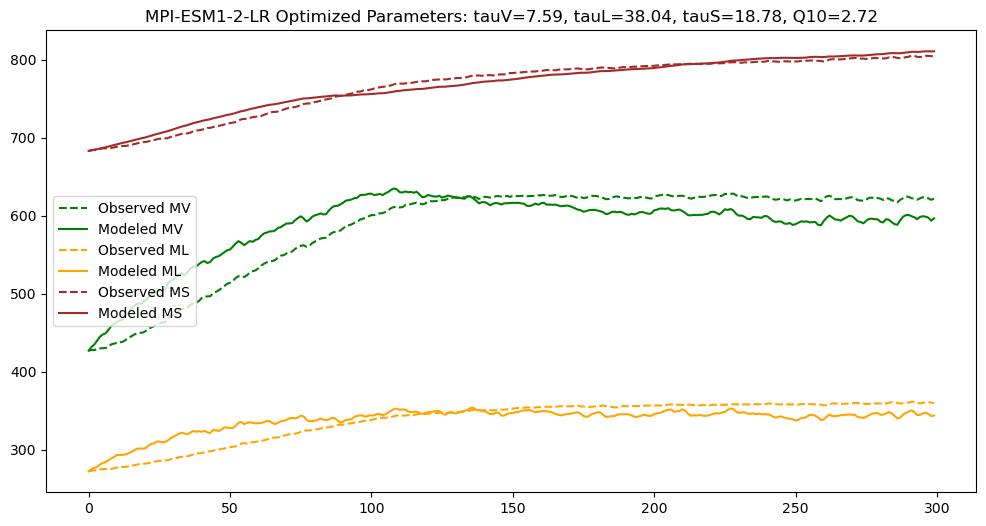

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1510.6710997521868
        x: [ 1.586e+01  8.048e+01  8.751e+01  3.475e+00]
      nit: 58
      jac: [-3.174e-02  3.342e-03 -9.550e-04 -6.321e-02]
     nfev: 430
     njev: 86
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


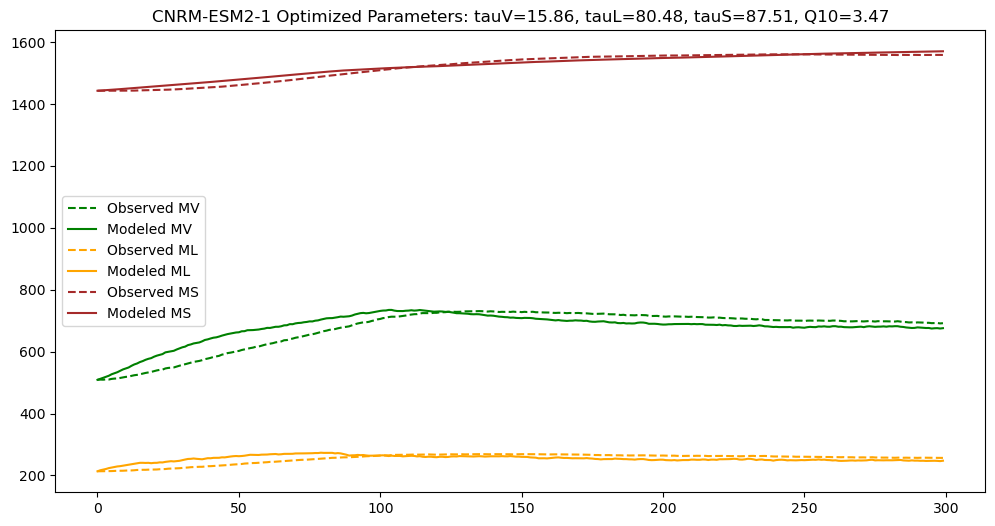

In [140]:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            #'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1']#,
            #'HadCM3LC-Bris',
            #'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year
Tbase= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
tauV_vec=np.empty(len(modellist))
tauL_vec=np.empty(len(modellist))
tauS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition

    if np.isnan(ML_obs).any():
        print('no litter')

    
    # #--- GPP
    # GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    # GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs
    
    # Initial guess and bounds
    initial_guess = [20,20,20, 1]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1, 1e3), (1.01, 1e3), (1, 1e3), (1e-3,1e2)]
    
    # Run optimization
    result = minimize(objective_3box_cnstQ10, x0=initial_guess, bounds=bounds)
    tauV_opt, tauL_opt, tauS_opt, Q10_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, ML_best, MS_best, Q10_best = simulate_model_3box_cnstQ10(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
    plt.plot(ML_best, label='Modeled ML',color='orange')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={tauV_opt:.2f}, tauL={tauL_opt:.2f}, tauS={tauS_opt:.2f}, Q10={Q10_opt:.2f}')
    plt.show()

    tauV_vec[m]=tauV_opt
    tauL_vec[m]=tauL_opt
    tauS_vec[m]=tauS_opt
    Q10_vec[m]=Q10_best
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    

In [142]:
## - this is the box model!

# 2 Box model, constant Q10

# Simulation function
def simulate_model_2box_cnstQ10(tau_params):
    tauV, tauS, Q10 = tau_params
    if tauV <= 0  or tauS <= 0 or Q10 <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], MS[0] = MV0, MS0

    for y in range(1, n):
        MS[y-1] = max(MS[y-1], 1e-6)
        
        denom = (1 / tauS) * MS[y-1]
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}, MS[y-1]={MS[y-1]},tauS={tauS}")
            return None
        RH = ( (1 / tauS) * MS[y-1])*np.exp((T[y]/10)*np.log(Q10))
        ##Q10[y] = np.exp(10 / T[y] * np.log(RH[y] / denom))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        MS[y] = MS[y-1] + dt * (
            MV[y-1] / tauV - (1 / tauS) * MS[y-1] * Q10**(T[y]/10)
        )

    return MV, MS, Q10

# Objective function
def objective_2box_cnstQ10(tau_params):
    result = simulate_model_2box_cnstQ10(tau_params)
    if result is None:
        return np.inf
    MV, MS, Q10 = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((MS - MS_obs)**2) * 1.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 289.14798919430956
        x: [ 1.502e+01  1.162e+01  1.334e+00]
      nit: 26
      jac: [-1.398e-02 -2.234e-03 -2.811e-02]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


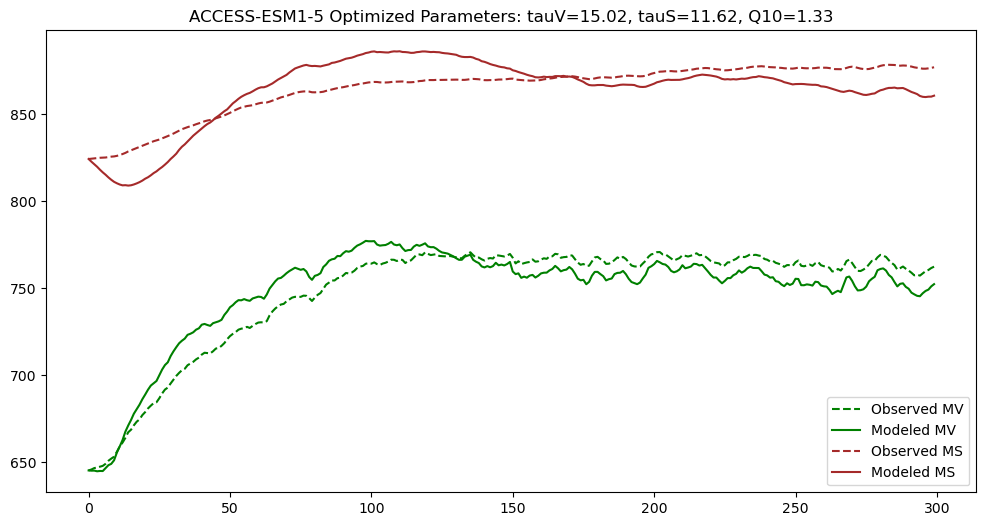

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 756.6232332304206
        x: [ 1.565e+01  5.797e+00  3.253e+00]
      nit: 61
      jac: [-2.535e-03  7.640e-03  1.961e-02]
     nfev: 316
     njev: 79
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


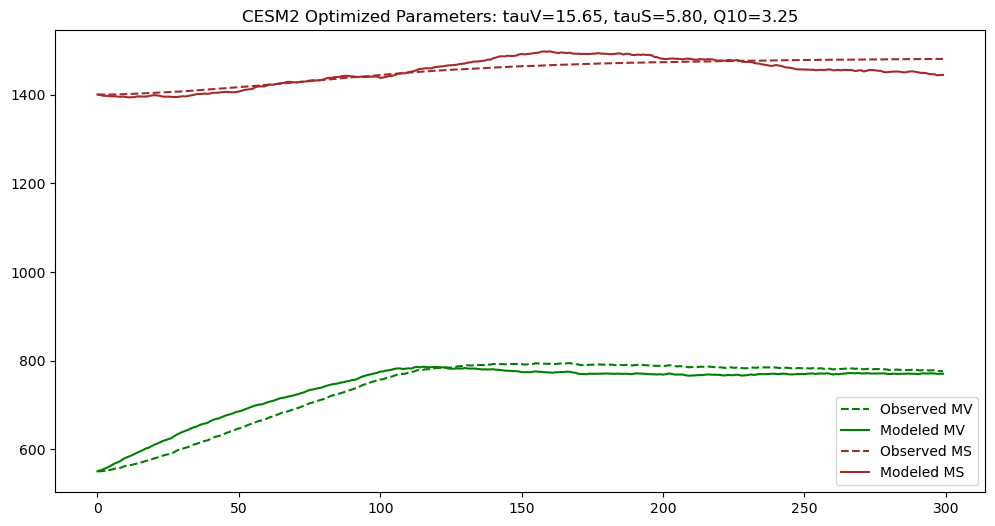

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1229.8281423854646
        x: [ 9.540e+00  1.000e+00  2.929e+00]
      nit: 59
      jac: [-4.547e-05  6.465e+01  2.274e-05]
     nfev: 312
     njev: 78
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


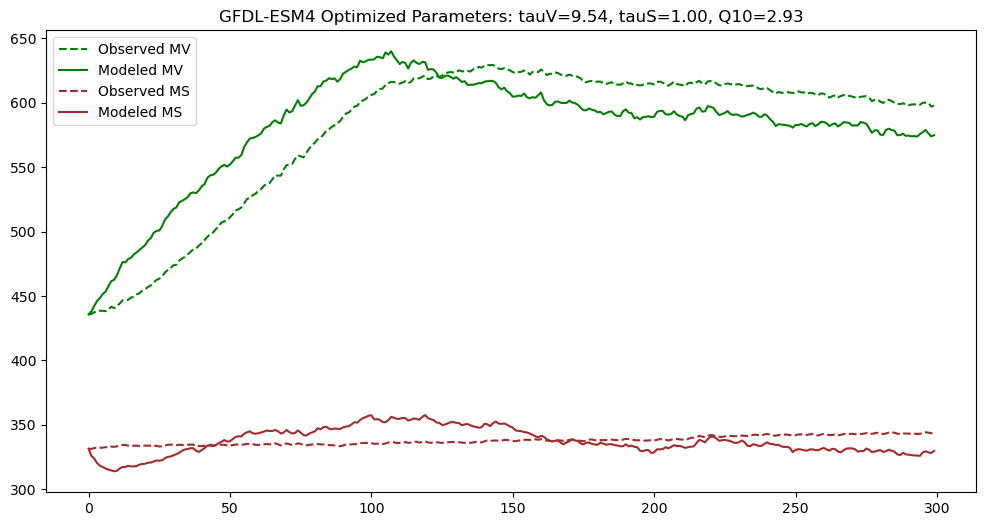

estimating parameters for model: GISS_E2.1
no litter
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1219.23682368786
        x: [ 1.584e+01  4.948e+00  5.127e+00]
      nit: 73
      jac: [ 2.274e-05 -2.115e-03 -2.797e-03]
     nfev: 388
     njev: 97
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


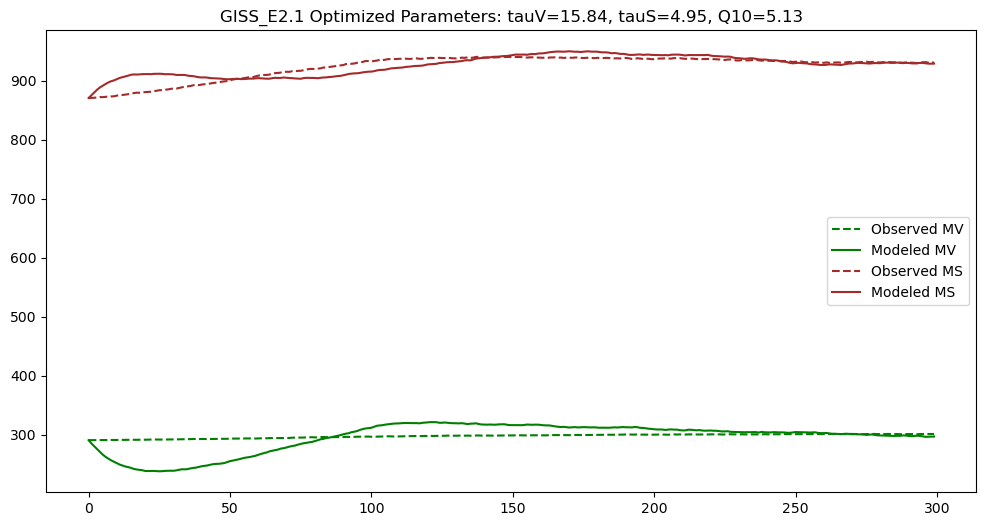

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 693.6812973170082
        x: [ 1.584e+01  3.050e+00  7.619e+00]
      nit: 110
      jac: [ 1.023e-03 -2.779e-02 -1.701e-02]
     nfev: 588
     njev: 147
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


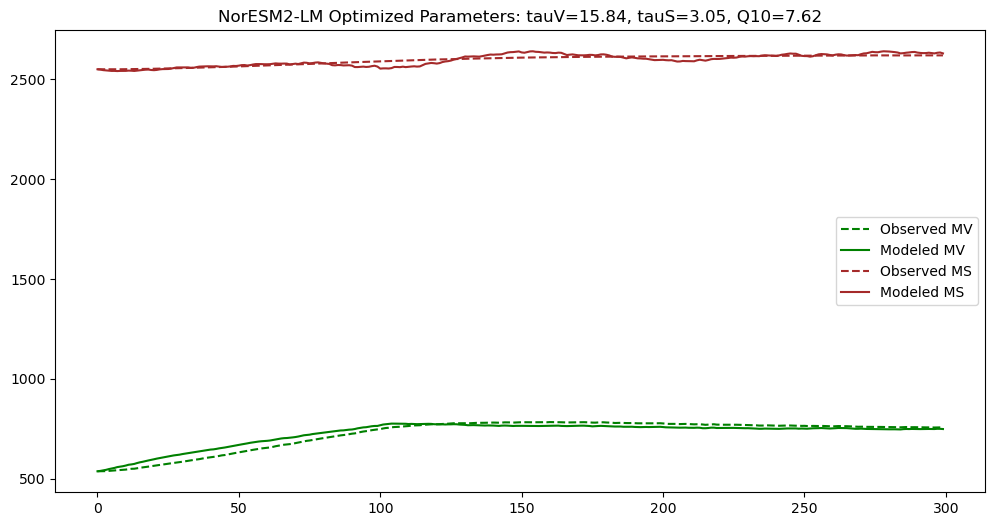

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2166.6530110363356
        x: [ 7.584e+00  2.225e+00  2.590e+00]
      nit: 57
      jac: [ 4.820e-03 -8.185e-04 -1.182e-03]
     nfev: 308
     njev: 77
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


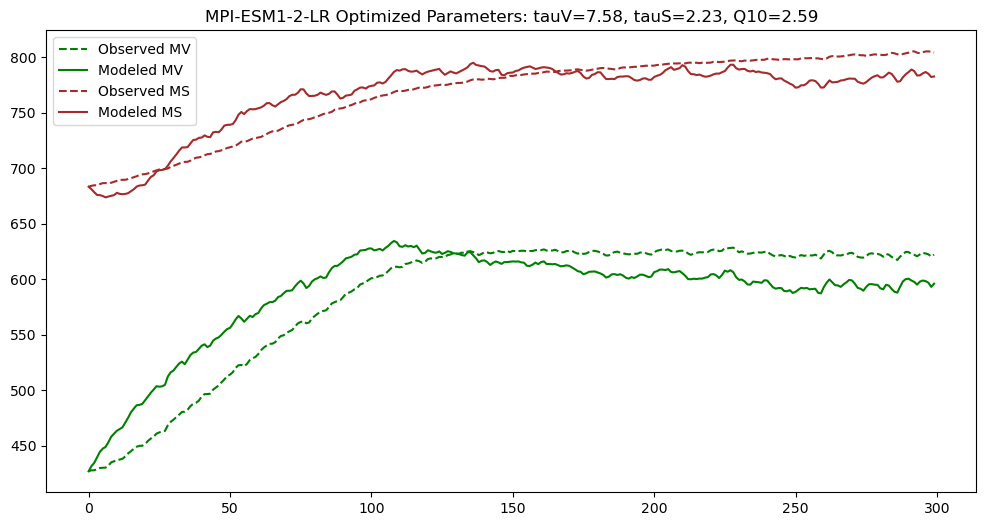

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2206.6765557042645
        x: [ 1.582e+01  1.512e+01  1.781e+00]
      nit: 46
      jac: [ 2.774e-03  4.320e-03  5.871e-02]
     nfev: 220
     njev: 55
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


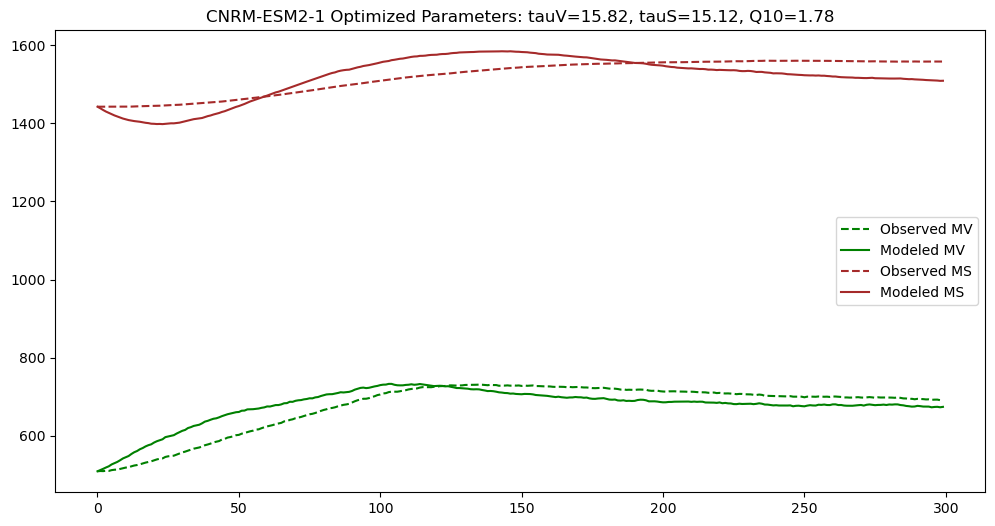

estimating parameters for model: HadCM3LC-Bris
no litter
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3349.798198678641
        x: [ 8.603e+00  4.568e+00  2.199e+00]
      nit: 40
      jac: [-2.728e-04 -3.365e-02 -1.151e-01]
     nfev: 200
     njev: 50
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


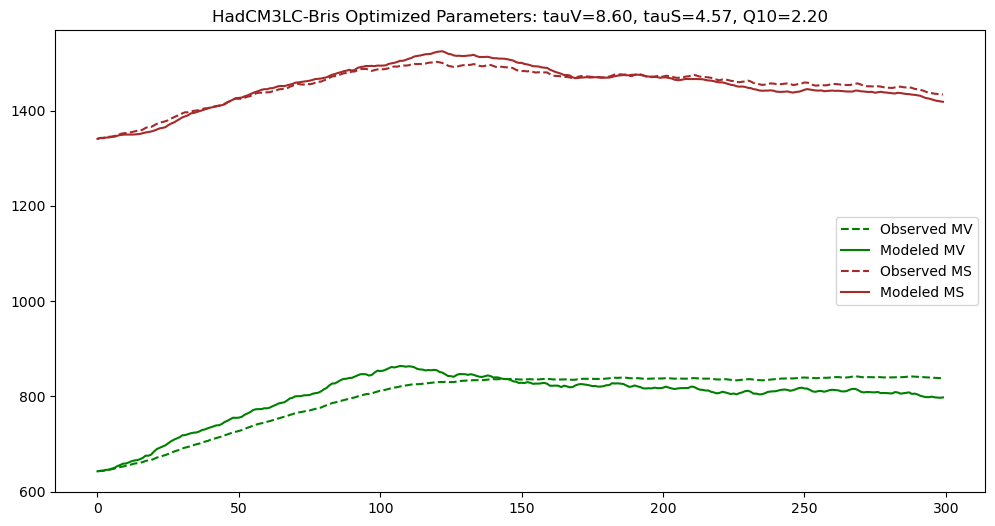

estimating parameters for model: UKESM1.2
no litter
Invalid Q10 input at step 3: denom=nan, T=-17.042536112803305, MS[y-1]=nan,tauS=20.0
Invalid Q10 input at step 3: denom=nan, T=-17.042536112803305, MS[y-1]=nan,tauS=20.0
Invalid Q10 input at step 3: denom=nan, T=-17.042536112803305, MS[y-1]=nan,tauS=20.00000001
Invalid Q10 input at step 3: denom=nan, T=-17.042536112803305, MS[y-1]=nan,tauS=20.0
Invalid Q10 input at step 1: denom=nan, T=-16.751260202031574, MS[y-1]=1737.7314684473217,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-16.751260202031574, MS[y-1]=1737.7314684473217,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-16.751260202031574, MS[y-1]=1737.7314684473217,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-16.751260202031574, MS[y-1]=1737.7314684473217,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-16.751260202031574, MS[y-1]=1737.7314684473217,tauS=nan
Invalid Q10 input at step 1: denom=nan, T=-16.751260202031574, MS[y-1]=1737.7314684473217,tauS=nan
Invalid

TypeError: cannot unpack non-iterable NoneType object

In [146]:
# 2 box, constant Q10
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year
Tbase= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
tauV_vec=np.empty(len(modellist))
tauS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition

    if np.isnan(ML_obs).any():
        print('no litter')

    
    # #--- GPP
    # GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    # GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs
    
    # Initial guess and bounds
    initial_guess = [20,20, 1]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1, 1e3), (1, 1e3), (1e-3,1e2)]
    
    # Run optimization
    result = minimize(objective_2box_cnstQ10, x0=initial_guess, bounds=bounds)
    tauV_opt, tauS_opt, Q10_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, MS_best, Q10_best = simulate_model_2box_cnstQ10(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={tauV_opt:.2f}, tauS={tauS_opt:.2f}, Q10={Q10_opt:.2f}')
    plt.show()

    tauV_vec[m]=tauV_opt
    tauS_vec[m]=tauS_opt
    Q10_vec[m]=Q10_best
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    

In [147]:
## - this is the box model!

# 3 Box model, no Q10

# Simulation function
def simulate_model_3box_noQ10(tau_params):
    tauV, tauL, tauS = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)

        RH = ((1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1])
        #denom = (1 - 1 / tauL) * ML[y-1] + (1 / tauS) * MS[y-1]
        if RH <= 0 or np.isnan(RH):
            print(f"Invalid Q10 input at step {y}: RH={denom},  ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},tauL={tauL},tauS={tauS}")
            return None
        
        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 - 1 / tauL) * ML[y-1] 
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] 
        )

    return MV, ML, MS

# Objective function
def objective_3box_noQ10(tau_params):
    result = simulate_model_3box_noQ10(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 2.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 1.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 334.06987232681354
        x: [ 1.503e+01  4.536e+01  1.000e+03]
      nit: 33
      jac: [ 8.754e-04 -1.705e-05 -7.924e-03]
     nfev: 188
     njev: 47
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


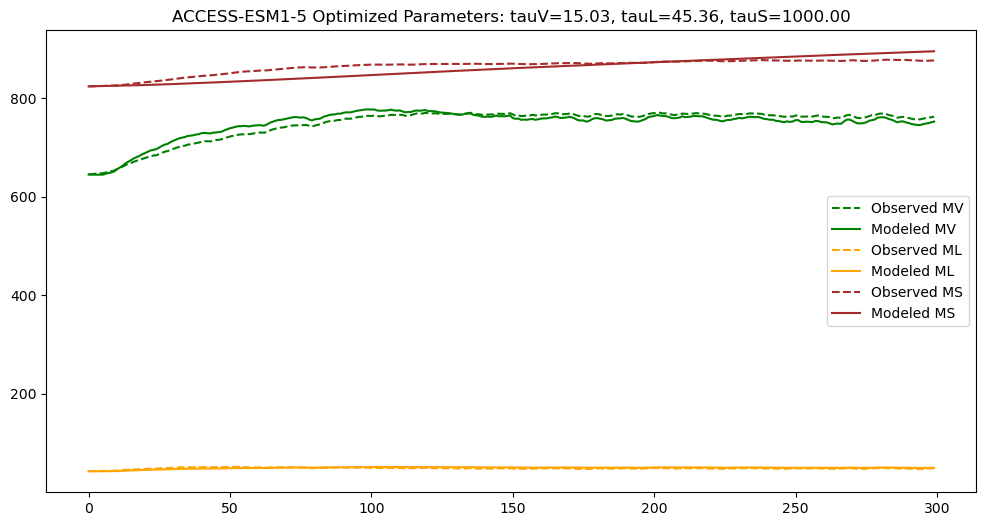

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 746.6888474618656
        x: [ 1.565e+01  2.618e+01  1.000e+03]
      nit: 25
      jac: [ 2.399e-03  2.058e-03 -1.177e-01]
     nfev: 124
     njev: 31
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


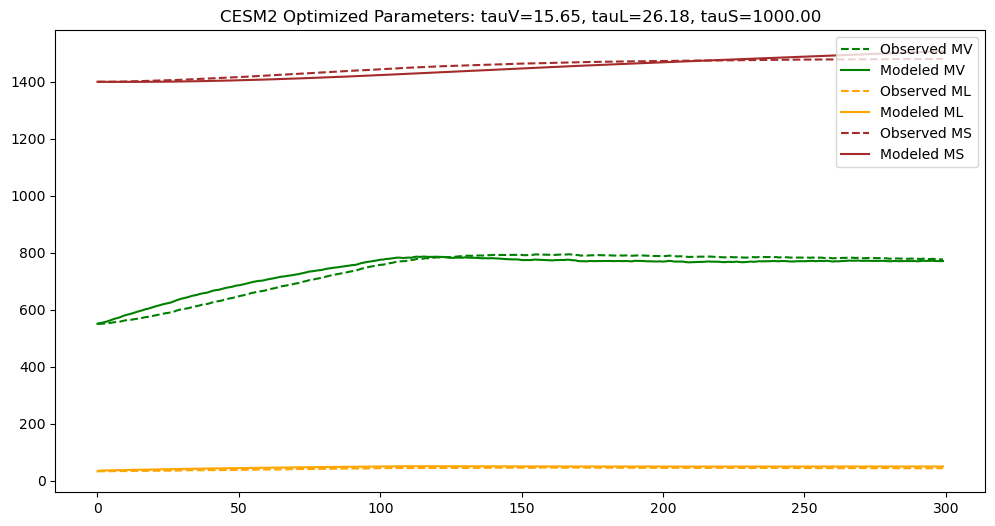

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 119147.57643794734
        x: [ 9.525e+00  1.187e+02  7.035e+02]
      nit: 25
      jac: [-1.221e+00  4.584e-01 -7.567e-02]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


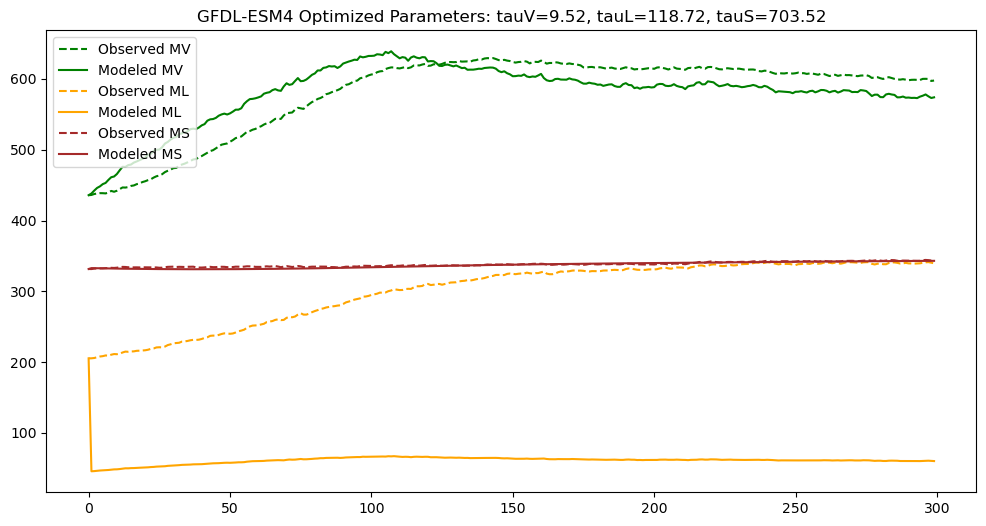

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 939.2706787449312
        x: [ 1.584e+01  1.567e+01  1.000e+03]
      nit: 20
      jac: [-3.411e-04  1.933e-03 -3.833e-01]
     nfev: 116
     njev: 29
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


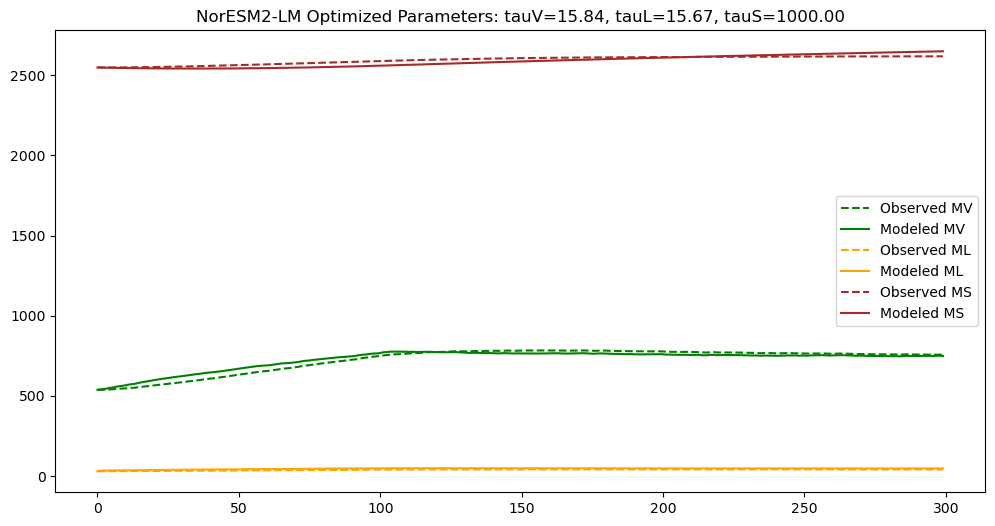

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 138514.64979843207
        x: [ 7.559e+00  8.060e+00  8.239e+01]
      nit: 30
      jac: [-2.328e-02  1.601e-01 -1.455e-02]
     nfev: 208
     njev: 52
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


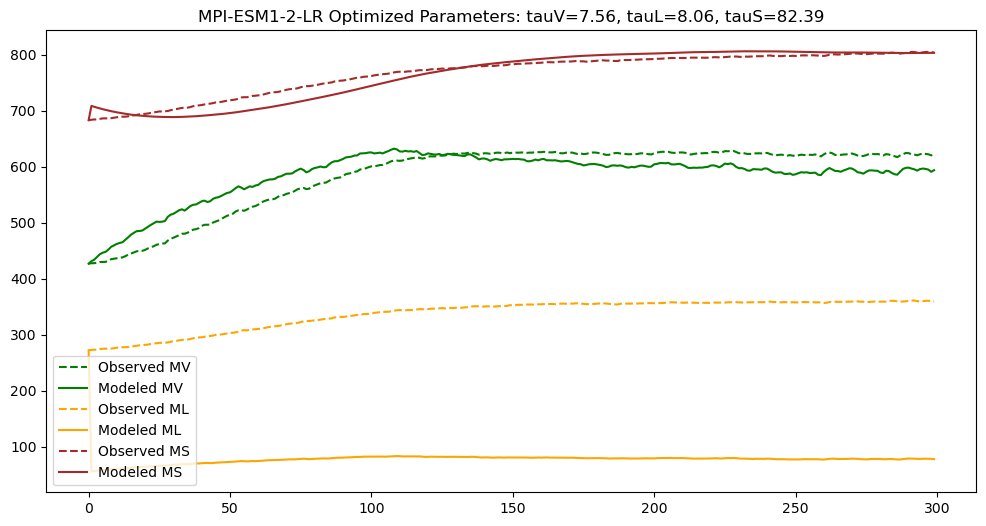

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 91170.30362029499
        x: [ 1.579e+01  4.697e+00  1.723e+02]
      nit: 26
      jac: [ 8.731e-02  6.112e-01 -1.601e-02]
     nfev: 184
     njev: 46
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


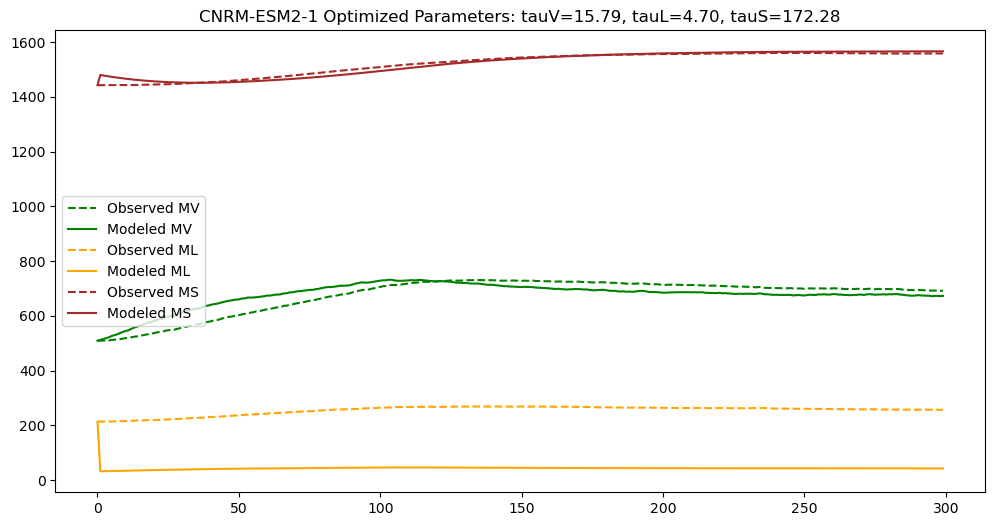

In [150]:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            #'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1']#,
            #'HadCM3LC-Bris',
            #'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year
Tbase= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
tauV_vec=np.empty(len(modellist))
tauL_vec=np.empty(len(modellist))
tauS_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition

    if np.isnan(ML_obs).any():
        print('no litter')

    
    # #--- GPP
    # GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    # GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs
    
    # Initial guess and bounds
    initial_guess = [20,20,20]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1, 1e3), (1.01, 1e3), (1, 1e3)]
    
    # Run optimization
    result = minimize(objective_3box_noQ10, x0=initial_guess, bounds=bounds)
    tauV_opt, tauL_opt, tauS_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, ML_best, MS_best = simulate_model_3box_noQ10(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
    plt.plot(ML_best, label='Modeled ML',color='orange')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={tauV_opt:.2f}, tauL={tauL_opt:.2f}, tauS={tauS_opt:.2f}')
    plt.show()

    tauV_vec[m]=tauV_opt
    tauL_vec[m]=tauL_opt
    tauS_vec[m]=tauS_opt
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    

In [153]:
## - this is the box model!

# 3 Box model, constant Q10

# Simulation function
def simulate_model_3box_cnstQ10_4tau(tau_params):
    tauV, tauL, tauS, Q10, tauLR = tau_params
    if tauV <= 0 or tauL <= 0 or tauS <= 0 or Q10 <= 0 or tauLR <=0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        
        denom = ((1 / tauLR) * ML[y-1] + (1 / tauS) * MS[y-1])
        if denom <= 0 or np.isnan(denom) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: denom={denom}, T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},tauL={tauL},tauS={tauS},tauLR={tauLR}")
            return None
        RH = ((1 / tauLR) * ML[y-1] + (1 / tauS) * MS[y-1])*np.exp((T[y]/10)*np.log(Q10))

        MV[y] = MV[y-1] + dt * (NPP[y] - MV[y-1] / tauV)
        ML[y] = ML[y-1] + dt * (
            MV[y-1] / tauV - ML[y-1] / tauL - (1 / tauLR) * ML[y-1] * Q10**(T[y]/10)
        )
        MS[y] = MS[y-1] + dt * (
            ML[y-1] / tauL - (1 / tauS) * MS[y-1] * Q10**(T[y]/10)
        )

    return MV, ML, MS, Q10

# Objective function
def objective_3box_cnstQ10_4tau(tau_params):
    result = simulate_model_3box_cnstQ10_4tau(tau_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 1.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 2.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 223.51315093980895
        x: [ 1.502e+01  3.731e+00  4.651e+01  1.262e+00  1.010e+00]
      nit: 175
      jac: [ 6.497e-03 -4.265e-02  4.400e-03  3.905e-01  2.144e+02]
     nfev: 1290
     njev: 215
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


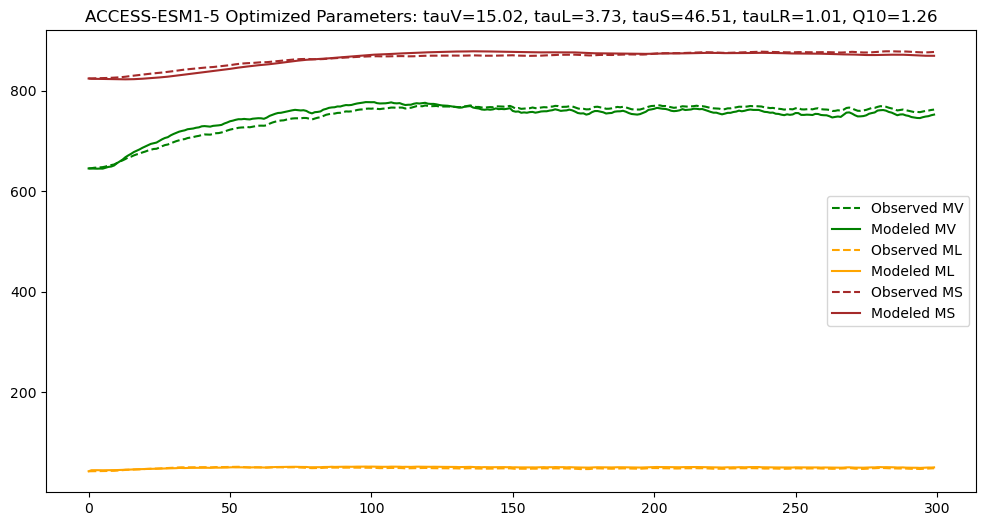

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 890.8315097257861
        x: [ 1.564e+01  1.189e+00  9.964e+00  2.666e+00  1.010e+00]
      nit: 86
      jac: [-1.373e-02 -2.506e-02  1.406e-02  9.270e-02  2.273e+02]
     nfev: 696
     njev: 116
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


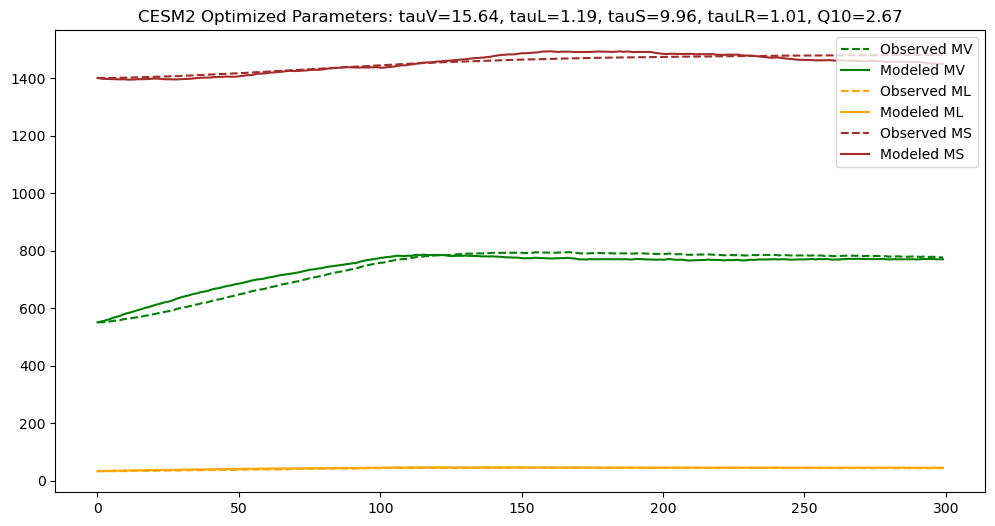

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 187639.5274868818
        x: [ 7.725e+00  5.099e+02  2.056e+01  1.454e+00  4.152e+00]
      nit: 19
      jac: [-1.354e+04  6.713e+01 -3.244e+03  3.241e+04  2.349e+04]
     nfev: 258
     njev: 43
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


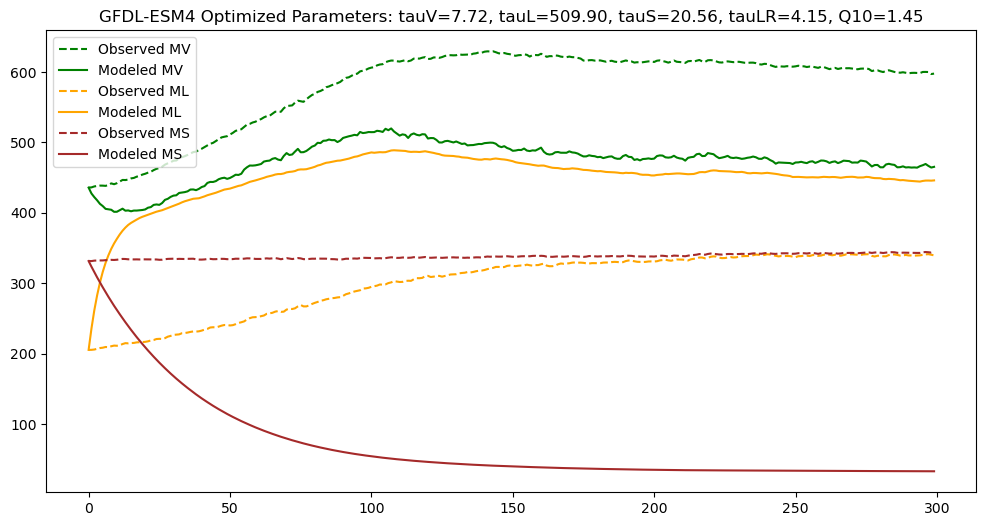

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 948.3553822753789
        x: [ 1.583e+01  1.010e+00  3.477e+00  7.240e+00  1.010e+00]
      nit: 127
      jac: [ 5.082e-03  4.674e+02 -1.942e-01 -1.404e-01  7.860e+01]
     nfev: 1062
     njev: 177
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


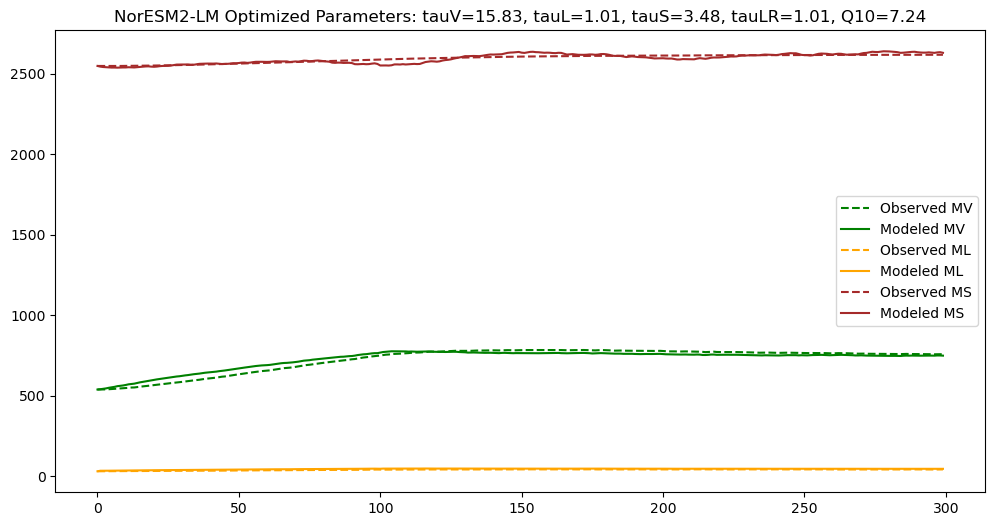

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2109.356348829051
        x: [ 7.585e+00  2.178e+01  1.731e+01  1.978e+00  1.877e+00]
      nit: 159
      jac: [-4.911e-03 -3.092e-03  4.957e-03  1.109e-01  3.101e-02]
     nfev: 1236
     njev: 206
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


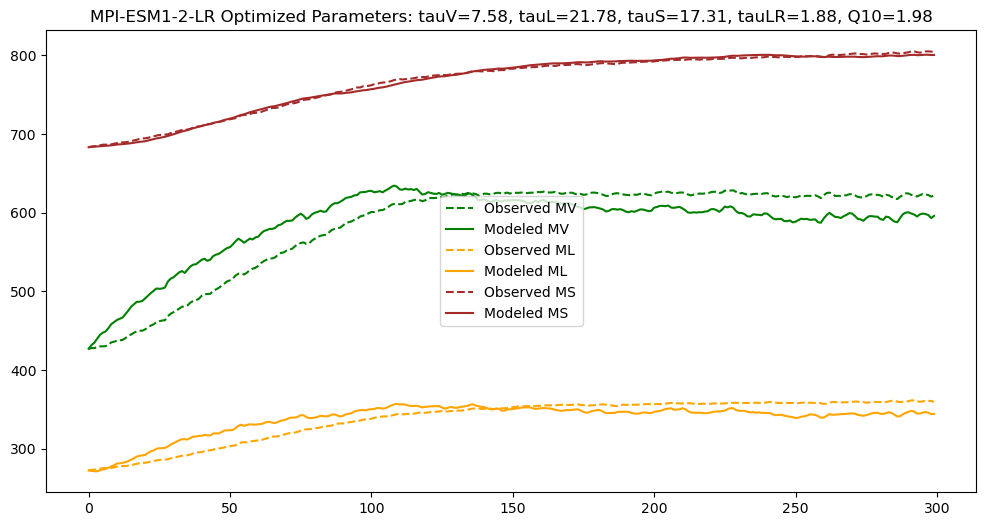

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1042.5669148560423
        x: [ 1.583e+01  2.626e+01  7.289e+01  1.721e+00  3.449e+00]
      nit: 138
      jac: [-5.027e-02 -3.076e-02  1.405e-02  1.618e+00  2.512e-01]
     nfev: 1062
     njev: 177
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


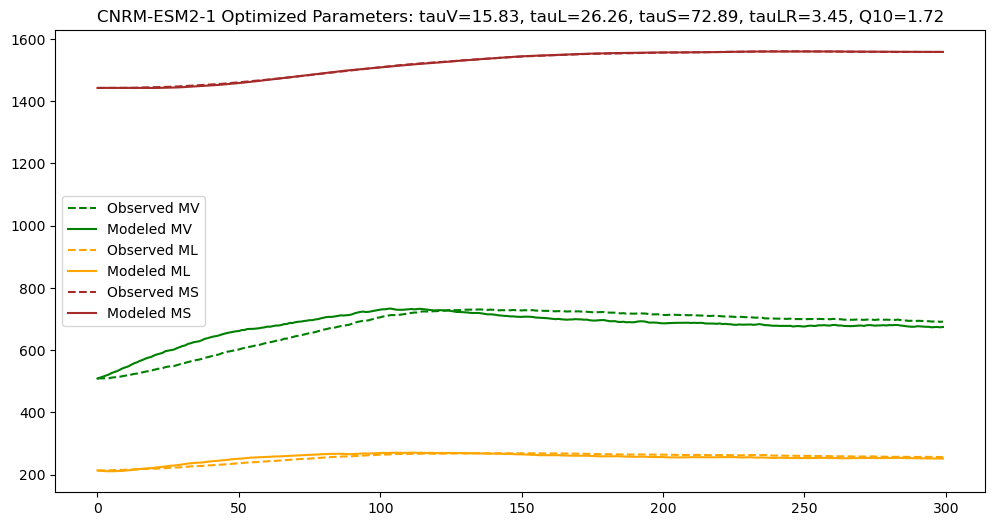

In [154]:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            #'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1']#,
            #'HadCM3LC-Bris',
            #'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year
Tbase= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
tauV_vec=np.empty(len(modellist))
tauL_vec=np.empty(len(modellist))
tauS_vec=np.empty(len(modellist))
tauLR_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition

    if np.isnan(ML_obs).any():
        print('no litter')

    
    # #--- GPP
    # GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    # GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs
    
    # Initial guess and bounds
    initial_guess = [20,20,20, 1,20]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1, 1e3), (1.01, 1e3), (1, 1e3), (1e-3,1e2), (1.01, 1e3)]
    
    # Run optimization
    result = minimize(objective_3box_cnstQ10_4tau, x0=initial_guess, bounds=bounds)
    tauV_opt, tauL_opt, tauS_opt, Q10_opt, tauLR_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, ML_best, MS_best, Q10_best = simulate_model_3box_cnstQ10_4tau(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
    plt.plot(ML_best, label='Modeled ML',color='orange')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={tauV_opt:.2f}, tauL={tauL_opt:.2f}, tauS={tauS_opt:.2f}, tauLR={tauLR_opt:.2f}, Q10={Q10_opt:.2f}')
    plt.show()

    tauV_vec[m]=tauV_opt
    tauL_vec[m]=tauL_opt
    tauS_vec[m]=tauS_opt
    tauLR_vec[m]=tauLR_opt
    Q10_vec[m]=Q10_best
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    

In [160]:
## - this is the box model!

# 3 Box model, constant Q10, use fraction instead of tau

# Simulation function
def simulate_model_3box_cnstQ10_f(f_params):
    fV, fL, fS, Q10 = f_params
    if fV <= 0 or fL <= 0 or fS <= 0 or Q10 <= 0:
        return None  # for bounds enforcement

    n = len(NPP)
    MV = np.zeros(n)
    ML = np.zeros(n)
    MS = np.zeros(n)
    RH = np.zeros(n)

    MV[0], ML[0], MS[0] = MV0, ML0, MS0

    for y in range(1, n):
        ML[y-1] = max(ML[y-1], 1e-6)
        MS[y-1] = max(MS[y-1], 1e-6)
        
        if np.isnan(ML[y-1]) or np.isnan(MS[y-1]) or np.isnan(T[y]) or T[y] == 0:
            print(f"Invalid Q10 input at step {y}: T={T[y]}, ML[y-1]={ML[y-1]}, MS[y-1]={MS[y-1]},fL={fL},fS={fS}")
            return None
        RH = ((1-fL) * ML[y-1] + (fS * MS[y-1]))*np.exp((T[y]/10)*np.log(Q10))

        MV[y] = MV[y-1] + dt * (NPP[y] - fV*MV[y-1])
        ML[y] = ML[y-1] + dt * (
            fV*MV[y-1] - fL*ML[y-1] - (1 - fL) * ML[y-1] * Q10**(T[y]/10)
        )
        MS[y] = MS[y-1] + dt * (
            fL*ML[y-1] - fS * MS[y-1] * Q10**(T[y]/10)
        )

    return MV, ML, MS, Q10

# Objective function
def objective_3box_cnstQ10_f(f_params):
    result = simulate_model_3box_cnstQ10_f(f_params)
    if result is None:
        return np.inf
    MV, ML, MS, Q10 = result
    # Mean squared error across all three time series
    # loss = (
    #     np.mean((MV - MV_obs) ** 2) +
    #     np.mean((ML - ML_obs) ** 2) +
    #     np.mean((MS - MS_obs) ** 2)
    # )

    loss = (
    np.mean((MV - MV_obs)**2) * 1.0 +
    np.mean((ML - ML_obs)**2) * 1.0 +  # Increase weight
    np.mean((MS - MS_obs)**2) * 2.0 +
    np.mean((RH-RH_obs)**2) * 1.0
    )
    return loss

estimating parameters for model: ACCESS-ESM1-5
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 417.78697060475645
        x: [ 6.662e-02  8.835e-01  7.809e-02  1.324e+00]
      nit: 42
      jac: [-2.204e+00 -1.592e-01  2.290e+00 -1.304e-01]
     nfev: 455
     njev: 91
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


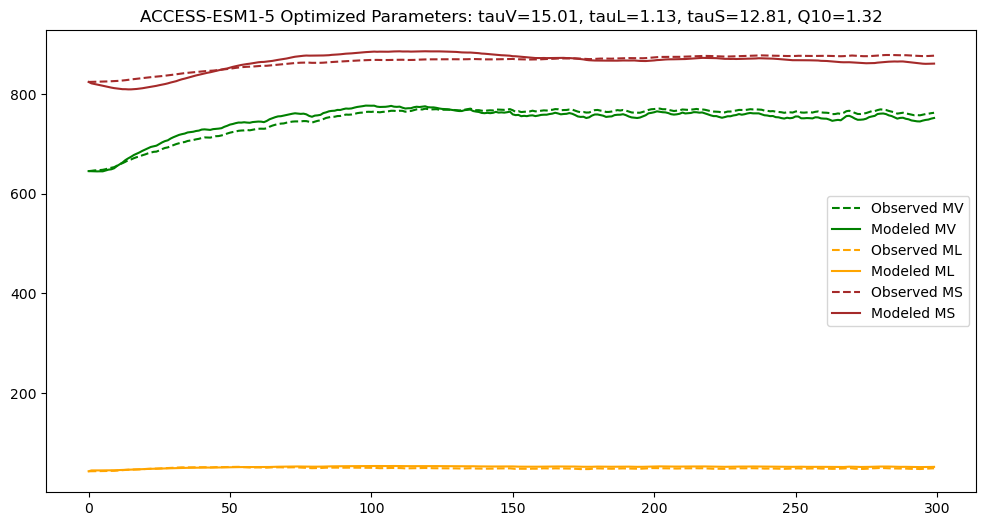

estimating parameters for model: CESM2
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1079.7866451884368
        x: [ 6.394e-02  1.000e+00  1.818e-01  3.378e+00]
      nit: 41
      jac: [ 8.132e-01 -3.963e+02  1.091e+00 -8.113e-02]
     nfev: 325
     njev: 65
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


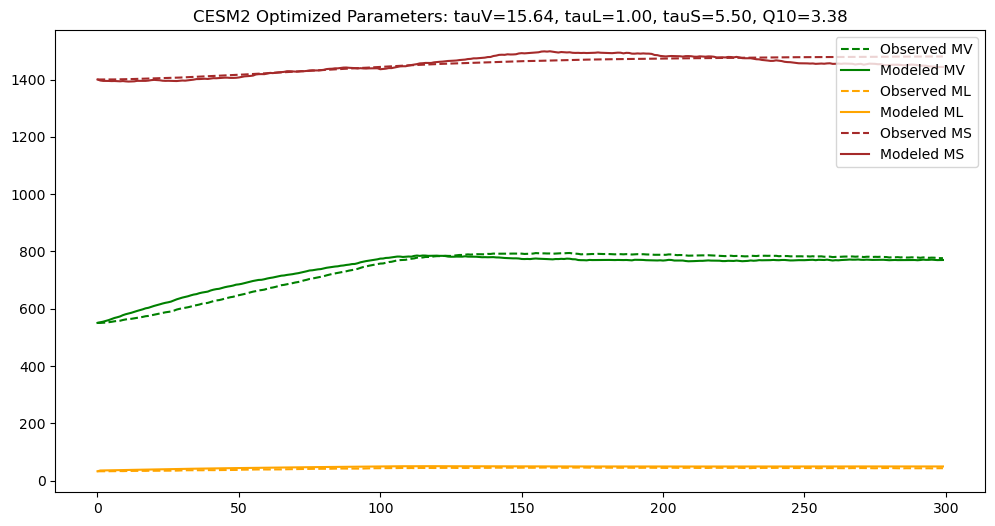

estimating parameters for model: GFDL-ESM4
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2750.5243055433943
        x: [ 1.045e-01  1.124e-01  1.000e+00  4.238e+00]
      nit: 50
      jac: [ 2.274e-04 -2.728e-04 -8.672e+01 -4.547e-05]
     nfev: 485
     njev: 97
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


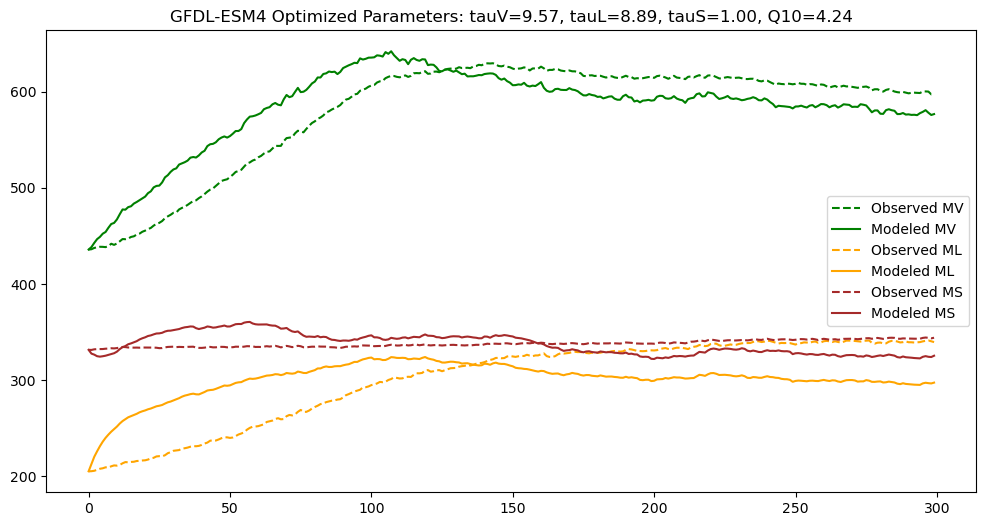

estimating parameters for model: NorESM2-LM
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1020.2230341085934
        x: [ 6.318e-02  1.000e+00  3.594e-01  8.128e+00]
      nit: 32
      jac: [ 1.760e-02 -6.910e+02 -1.030e+00  6.319e-02]
     nfev: 265
     njev: 53
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


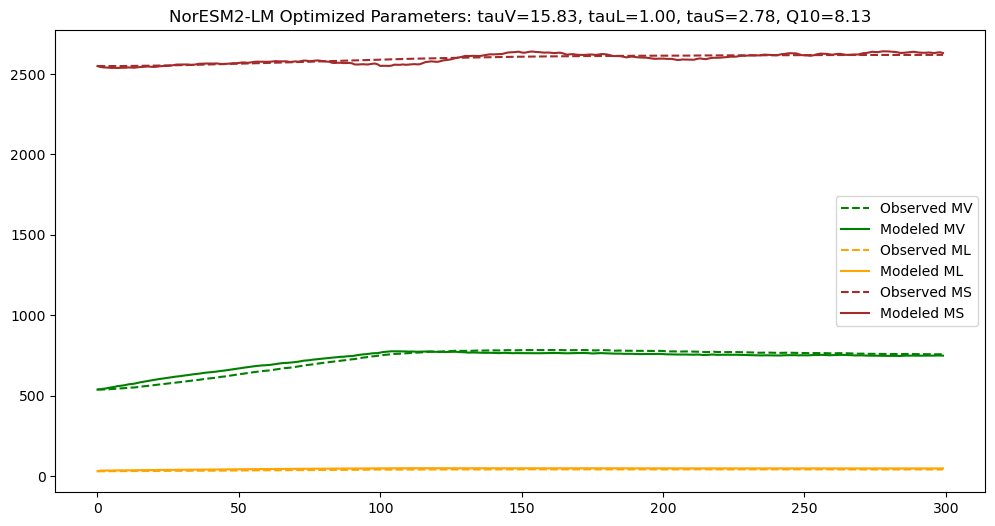

estimating parameters for model: MPI-ESM1-2-LR
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2233.848022952173
        x: [ 1.318e-01  2.506e-02  5.035e-02  2.710e+00]
      nit: 61
      jac: [ 5.293e+00  1.179e+01 -6.137e+00  4.192e-01]
     nfev: 565
     njev: 113
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


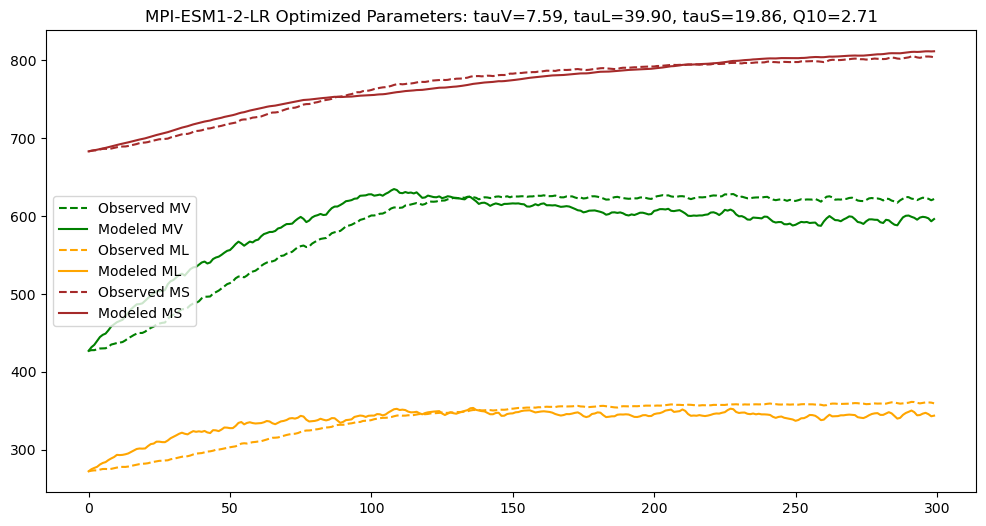

estimating parameters for model: CNRM-ESM2-1
Optimization Result:   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1394.8115444711511
        x: [ 6.309e-02  1.175e-02  1.066e-02  3.467e+00]
      nit: 40
      jac: [ 5.730e-03 -9.095e-04 -2.274e-04 -1.091e-03]
     nfev: 305
     njev: 61
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


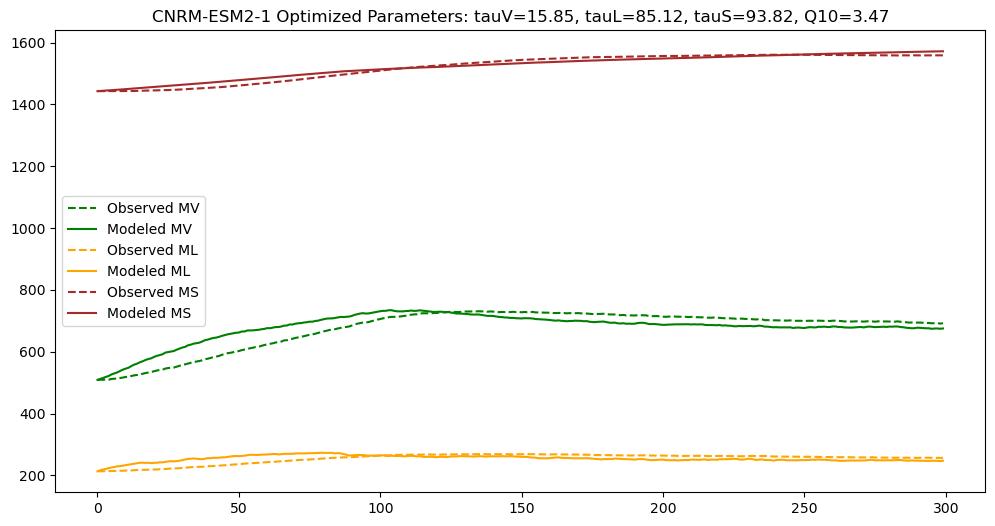

In [162]:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            #'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1']#,
            #'HadCM3LC-Bris',
            #'UKESM1.2']


latrange='global'
dt=1 # timestep is 1 year
Tbase= 298.15 # base temperature (default is 25C)

# initialize some empty arrays to store outputs
fV_vec=np.empty(len(modellist))
fL_vec=np.empty(len(modellist))
fS_vec=np.empty(len(modellist))
Q10_vec=np.empty(len(modellist))

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]
    print ('estimating parameters for model: ' +model)

    # assign data from output

    #--- cLitter
    cLitter= get_full_ts_flat10(model, 'flat10_zec', 'cLitter', latrange)
    ML_obs= cLitter
    ML0=ML_obs[0] #specify initial condition

    if np.isnan(ML_obs).any():
        print('no litter')

    
    # #--- GPP
    # GPPo = get_full_ts_flat10(model, 'flat10_zec', 'gpp', latrange)
    # GPP= GPPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- TAS    
    To= get_full_ts_flat10(model, 'flat10_zec', 'tas', latrange)
    T = To-Tb #remove baseline temp
    
    #--- RH
    RHo= get_full_ts_flat10(model, 'flat10_zec', 'rh', latrange)
    RH_obs= RHo *  speryr #convert from Pg/s to Pg/yr
    
    #--- NBP
    NBPo= get_full_ts_flat10(model, 'flat10_zec', 'nbp', latrange)
    NBP= NBPo *  speryr #convert from Pg/s to Pg/yr
    
    #--- cVeg  
    cVeg= get_full_ts_flat10(model, 'flat10_zec', 'cVeg', latrange)
    MV_obs= cVeg 
    MV0=MV_obs[0]
    
    #--- cSoil
    cSoil= get_full_ts_flat10(model, 'flat10_zec', 'cSoil', latrange)
    MS_obs= cSoil 
    MS0=MS_obs[0] # specify initial condition

    
    # calculate NPP from nbp and rh 
    NPP=NBP + RH_obs
    
    # Initial guess and bounds
    initial_guess = [0.5,0.5,0.5, 1]#[15.5, 1.0, 30.0] # tau_V, tau_L, tau_S
    bounds = [(1e-3, 1), (1e-3, 1), (1e-3, 1), (1e-3,1e2)]
    
    # Run optimization
    result = minimize(objective_3box_cnstQ10_f, x0=initial_guess, bounds=bounds)
    fV_opt, fL_opt, fS_opt, Q10_opt = result.x
    print("Optimization Result:", result)
    
    # Simulate with optimal parameters
    MV_best, ML_best, MS_best, Q10_best = simulate_model_3box_cnstQ10_f(result.x)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(MV_obs, label='Observed MV',color='green',linestyle='--')
    plt.plot(MV_best, label=f'Modeled MV',color='green')
    plt.plot(ML_obs, label='Observed ML',color='orange',linestyle='--')
    plt.plot(ML_best, label='Modeled ML',color='orange')
    plt.plot(MS_obs, label='Observed MS',color='brown',linestyle='--')
    plt.plot(MS_best, label='Modeled MS',color='brown')
    plt.legend()
    plt.title(model +f' Optimized Parameters: tauV={(1/fV_opt):.2f}, tauL={(1/fL_opt):.2f}, tauS={(1/fS_opt):.2f}, Q10={Q10_opt:.2f}')
    plt.show()

    fV_vec[m]=fV_opt
    fL_vec[m]=fL_opt
    fS_vec[m]=fS_opt
    Q10_vec[m]=Q10_best
    
# #-- add output to a pandas data frame
# esm_bestfit = pd.DataFrame({})
# esm_bestfit['tauL']=tauL_opt


# mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

# esm_metrics_flat10.index=mdls

    